In [1]:
# -*- encoding:urf-8 -*-
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table like and matrices
import pandas as pd
import numpy as np

# Modeling Helper
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno

# Configure visualization
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 8,6

train_path = '../input/train.csv'
test_path = '../input/test.csv'
hol_path = '../input/holiday.csv'
train_date_path = '../input/train_date.csv'
cache_path = '../input/cache/'
output_path = '../output/'
train_new_path = 'train_new_total.csv'
train_new = pd.read_csv(train_new_path)
test = pd.read_csv(test_path)

### Helper Functions

In [2]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

In [3]:
saleCount_corr = train_new.corr()
cor_dict = saleCount_corr['saleCount'].to_dict()
del cor_dict['saleCount']
print("List the numerical features decendingly by their correlation with Sale Price:\n")
for ele in sorted(cor_dict.items(), key = lambda x: -abs(x[1])):
    print("{0}: \t{1}".format(*ele))

List the numerical features decendingly by their correlation with Sale Price:

wkDaySaleCount_mean: 	0.903377314936
holDaySaleCount_median: 	0.902789918462
wkDaySaleCount_median: 	0.901768348891
holDaySaleCount_mean: 	0.901031238295
cumType: 	0.889278742662
wkDaySaleCount_max: 	0.868649635172
holDaySaleCount_max: 	0.802304009358
Coupon: 	0.504851430765
parCumType: 	0.421211362038
Class: 	-0.367481763878
parClass: 	-0.221641081193
bonusWeekProb: 	0.0364778101505
wkHolRatio: 	0.0319342984173
bonusRatio: 	-0.0240492157534
dayOfWeek: 	-0.0198419055765
hotIndex: 	0.0172941088407
holidayCluster: 	-0.0157520964769
month: 	-0.0132823577483
dayOfYear: 	-0.0120976336761
parHotIndex: 	0.011296460301
weekOfYear: 	-0.0109207621
bonusNotHolRatio: 	-0.0106578866417
bonusHolRatio: 	0.0101139032555
disHoliday: 	0.000820899275428
wkDaySaleCount_min: 	nan
holDaySaleCount_min: 	nan


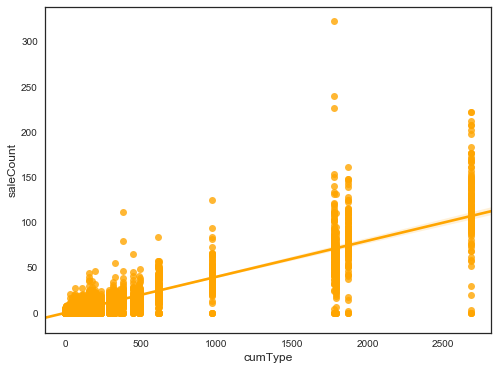

In [4]:
sns.regplot(x = 'cumType', y = 'saleCount', data = train_new, color = 'Orange')

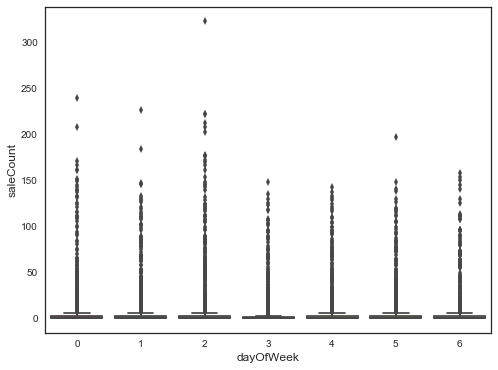

In [5]:
sns.boxplot(x = 'dayOfWeek', y = 'saleCount', data = train_new)

In [6]:
describe_more(train_new)


Datatype  Levels                Variable
22    int64       1     holDaySaleCount_min
18    int64       1      wkDaySaleCount_min
5     int64       3          holidayCluster
7     int64       4                   month
6   float64       6              disHoliday
8     int64       7               dayOfWeek
14  float64      14             parHotIndex
12  float64      15              parCumType
1     int64      15                parClass
10    int64      18              weekOfYear
15  float64      22   wkDaySaleCount_median
19  float64      29  holDaySaleCount_median
21    int64      36     holDaySaleCount_max
17    int64      41      wkDaySaleCount_max
4   float64      50                  Coupon
25  float64      78           bonusHolRatio
26  float64      94        bonusNotHolRatio
20  float64      95    holDaySaleCount_mean
24  float64     106              bonusRatio
16  float64     108     wkDaySaleCount_mean
13  float64     111                hotIndex
9     int64     120               dayOfYear
2    object     120                SaleDate
11  float64     133                 cumType
23  float64     139              wkHolRatio
3     int64     164               saleCount
0     int64     193                   Class
27  float64     271           bonusWeekProb

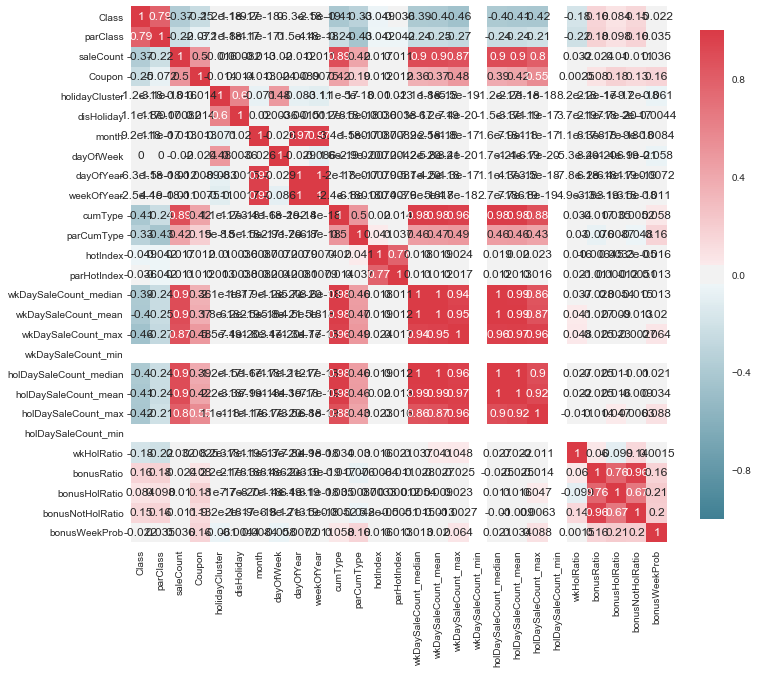

In [7]:
plot_correlation_map(train_new)

In [8]:
train_new['wkHolRatio'].value_counts()

2.000000    1320
0.000000    1080
1.000000    1080
4.000000     600
2.500000     360
3.000000     360
0.500000     360
1.166667     240
2.250000     240
0.600000     240
3.769231     240
2.600000     240
0.666667     240
5.000000     240
1.833333     240
7.000000     240
1.400000     240
0.625000     240
3.250000     240
2.666667     240
1.714286     240
6.000000     240
1.600000     240
0.750000     240
1.500000     240
1.910256     120
5.500000     120
1.770000     120
2.050562     120
1.965517     120
            ... 
2.714286     120
1.966667     120
1.722222     120
5.090909     120
0.733333     120
1.160000     120
2.471698     120
2.215198     120
0.714286     120
2.277778     120
2.946524     120
1.989899     120
2.187500     120
1.548077     120
1.666667     120
2.920000     120
0.900000     120
1.992565     120
1.708333     120
1.727273     120
0.958333     120
4.166667     120
1.459596     120
1.027027     120
2.064000     120
2.103245     120
2.803704     120
2.358491     1

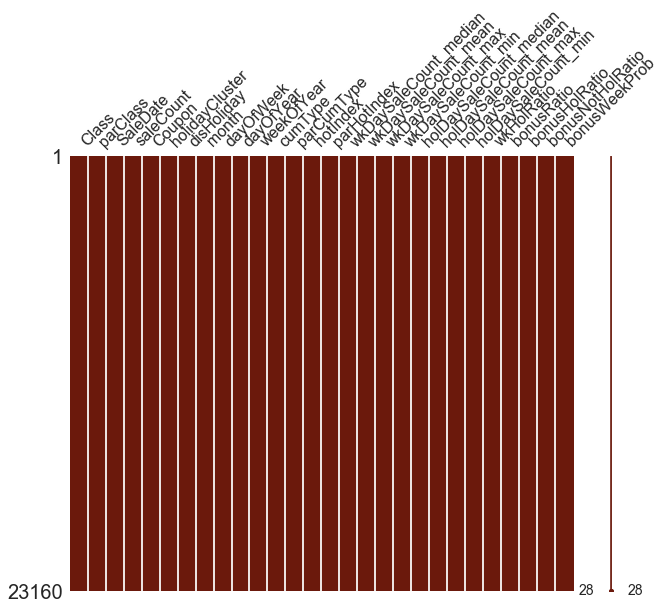

In [9]:
import missingno as msno
# Nullity or missing values by columns
msno.matrix(df=train_new.iloc[:,:], figsize=(10, 8), color=(0.42, 0.1, 0.05))

In [10]:
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr

#选择K个最好的特征，返回选择特征后的数据
#第一个参数为计算评估特征是否好的函数，该函数输入特征矩阵和目标向量，输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。在此定义为计算相关系数
#参数k为选择的特征个数
festures = train_new.columns
do_not_use = ['saleCount','SaleDate']
features_wanted = [f for f in festures if f not in do_not_use]
train_new.fillna(0,inplace=True)
# SelectKBest(lambda X, Y: array(map(lambda x:pearsonr(x, Y), X.T)).T, k=2).fit_transform(train_new[features_wanted], train_new['saleCount'])

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#选择K个最好的特征，返回选择特征后的数据
SelectKBest(chi2, k=2).fit_transform(train_new[features_wanted], train_new['saleCount'])

array([[ 175.86,  157.19],
       [ 175.86,  157.19],
       [ 175.86,  157.19],
       ..., 
       [  61.71,   61.71],
       [  61.71,   61.71],
       [  61.71,   61.71]])

In [11]:
def plot_ts_day(x,y):
    """绘制每天的时间序列图。
    需要注意的是，序列是不是连续的，也就是说某天的数据是没有的,因此需要采样至每天都有记录，原来数据没有的就填充0
    x:时间轴，string或者time类型,是一个seires
    y:值
    """
    # x转成时间类型Timestamp，y也转成list
    x=[pd.to_datetime(str(i)) for i in x]
    y=[i for i in y]
    s=pd.Series(y,index=x)
    s = s.resample(rule='D',fill_method='ffill') # 生采样没有的会被填充
    # 原来没有的就填充为0
    s[s.index]=0
    s[x]=y
    # 重建索引，画出来的图好看点
    x2 = [i.strftime('%Y-%m-%d') for i in s.index]
    s.index = x2
    # 画图，这里使用series的plot函数，而不是seaborn.tsplot函数
    s.plot()
#     plt.savefig(figName)
# var = train_new[train_new['Class'] == 2015].groupby('SaleDate',as_index=False)['saleCount'].mean()
# plot_ts_day(var['SaleDate'],var['saleCount'])
# plt.savefig('1004.jpg')

In [12]:
# plot_categories( train , cat = 'BigCode' , target = 'SaleNum' )

In [13]:
var = train.groupby('BigCode')['SaleNum'].sum()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('BigCode vs SalesNumber')
var.plot(kind='bar')
plt.show()

NameError: name 'train' is not defined

In [2]:
diff_tr2te = np.setdiff1d(train_new['Class'].unique(),test['Class'].unique())
diff_tr2te

array([  14, 1006, 1007, 1104, 1402, 1403, 1509, 1514, 2108, 2308, 2315,
       3009, 3012, 3015, 3101, 3104, 3106, 3108, 3111, 3115, 3120, 3121,
       3122, 3128, 3212, 3213, 3215, 3216, 3218, 3301, 3303, 3313, 3314,
       3315, 3328, 3330, 3401, 3404, 3406, 3409, 3410, 3412, 3416, 3419,
       3427, 3428, 3429, 3432, 3436], dtype=int64)

In [3]:
np.setdiff1d(test['Class'].unique(),train_new['Class'].unique())

array([1507, 3208, 3311, 3413], dtype=int64)

In [4]:
l_train = train_new['Class'].unique()
l_train_feat_wanted = [f for f in l_train if f not in diff_tr2te]
l_train_feat_wanted

[1001,
 1002,
 1004,
 1005,
 1099,
 1101,
 1102,
 1103,
 1201,
 1202,
 1203,
 1205,
 1301,
 1302,
 1306,
 1308,
 1501,
 1502,
 1503,
 1504,
 1505,
 1508,
 1510,
 1511,
 1512,
 1513,
 1515,
 1516,
 1517,
 1518,
 1519,
 1521,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2101,
 2102,
 2103,
 2104,
 2105,
 2106,
 2107,
 2201,
 2202,
 2203,
 2204,
 2205,
 2206,
 2207,
 2208,
 2209,
 2210,
 2211,
 2212,
 2301,
 2302,
 2303,
 2304,
 2305,
 2306,
 2307,
 2309,
 2310,
 2311,
 2312,
 2313,
 2314,
 2316,
 2317,
 3001,
 3002,
 3003,
 3004,
 3005,
 3006,
 3007,
 3008,
 3010,
 3011,
 3013,
 3014,
 3016,
 3017,
 3018,
 3102,
 3105,
 3107,
 3109,
 3110,
 3112,
 3113,
 3114,
 3116,
 3117,
 3118,
 3119,
 3125,
 3126,
 3217,
 3227,
 3316,
 3319,
 3320,
 3321,
 3322,
 3323,
 3325,
 3326,
 3402,
 3403,
 3407,
 3408,
 3415,
 3417,
 3423,
 3424,
 3426,
 3431,
 10,
 11,
 12,
 13,
 15,
 20,
 21,
 22,
 23,
 30,
 31,
 32,
 33,
 34]

In [22]:
train_new[train_new['Class'].isin(l_train_feat_wanted)]

Class  parClass    SaleDate  saleCount  Coupon  holidayCluster  \
0       1001        10  2015-01-01          3     0.0               3   
1       1001        10  2015-01-02          6     0.0               3   
2       1001        10  2015-01-03          7     0.0               3   
3       1001        10  2015-01-04          5     0.0               1   
4       1001        10  2015-01-05          9     0.0               1   
5       1001        10  2015-01-06          5     0.0               1   
6       1001        10  2015-01-07         28     0.0               1   
7       1001        10  2015-01-08          7     0.0               1   
8       1001        10  2015-01-09          4     0.0               1   
9       1001        10  2015-01-10          4     0.0               2   
10      1001        10  2015-01-11          3     0.0               2   
11      1001        10  2015-01-12         12     0.0               1   
12      1001        10  2015-01-13          5     0.0               1   
13      1001        10  2015-01-14         16     0.0               1   
14      1001        10  2015-01-15          9     0.0               1   
15      1001        10  2015-01-16          9     0.0               1   
16      1001        10  2015-01-17          3     0.0               2   
17      1001        10  2015-01-18          5     0.0               2   
18      1001        10  2015-01-19          4     0.0               1   
19      1001        10  2015-01-20          9     0.0               1   
20      1001        10  2015-01-21         25     0.0               1   
21      1001        10  2015-01-22          6     0.0               1   
22      1001        10  2015-01-23          7     0.0               1   
23      1001        10  2015-01-24          2     0.0               2   
24      1001        10  2015-01-25          5     0.0               2   
25      1001        10  2015-01-26         13     0.0               1   
26      1001        10  2015-01-27         12     0.0               1   
27      1001        10  2015-01-28         35     0.0               1   
28      1001        10  2015-01-29          9     0.0               1   
29      1001        10  2015-01-30          4     0.0               1   
...      ...       ...         ...        ...     ...             ...   
23130     34        34  2015-04-01          4     0.0               1   
23131     34        34  2015-04-02          1     0.0               1   
23132     34        34  2015-04-03          3     0.0               1   
23133     34        34  2015-04-04          2     0.0               3   
23134     34        34  2015-04-05          3     1.0               3   
23135     34        34  2015-04-06          1     0.0               3   
23136     34        34  2015-04-07          5     0.0               1   
23137     34        34  2015-04-08          2     1.0               1   
23138     34        34  2015-04-09          0     0.0               1   
23139     34        34  2015-04-10          2     0.0               1   
23140     34        34  2015-04-11          2     0.0               2   
23141     34        34  2015-04-12          3     0.0               2   
23142     34        34  2015-04-13          1     0.0               1   
23143     34        34  2015-04-14          7     1.0               1   
23144     34        34  2015-04-15          1     0.0               1   
23145     34        34  2015-04-16          0     0.0               1   
23146     34        34  2015-04-17          3     2.0               1   
23147     34        34  2015-04-18          1     0.0               2   
23148     34        34  2015-04-19          2     2.0               2   
23149     34        34  2015-04-20          5     1.0               1   
23150     34        34  2015-04-21          1     0.0               1   
23151     34        34  2015-04-22          3     2.0               1   
23152     34        34  2015-04-23          1     0.0            

## 训练集与测试集的商品交集

In [5]:
ll = [f for f in l_train if f not in diff_tr2te]
ll

[1001,
 1002,
 1004,
 1005,
 1099,
 1101,
 1102,
 1103,
 1201,
 1202,
 1203,
 1205,
 1301,
 1302,
 1306,
 1308,
 1501,
 1502,
 1503,
 1504,
 1505,
 1508,
 1510,
 1511,
 1512,
 1513,
 1515,
 1516,
 1517,
 1518,
 1519,
 1521,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2101,
 2102,
 2103,
 2104,
 2105,
 2106,
 2107,
 2201,
 2202,
 2203,
 2204,
 2205,
 2206,
 2207,
 2208,
 2209,
 2210,
 2211,
 2212,
 2301,
 2302,
 2303,
 2304,
 2305,
 2306,
 2307,
 2309,
 2310,
 2311,
 2312,
 2313,
 2314,
 2316,
 2317,
 3001,
 3002,
 3003,
 3004,
 3005,
 3006,
 3007,
 3008,
 3010,
 3011,
 3013,
 3014,
 3016,
 3017,
 3018,
 3102,
 3105,
 3107,
 3109,
 3110,
 3112,
 3113,
 3114,
 3116,
 3117,
 3118,
 3119,
 3125,
 3126,
 3217,
 3227,
 3316,
 3319,
 3320,
 3321,
 3322,
 3323,
 3325,
 3326,
 3402,
 3403,
 3407,
 3408,
 3415,
 3417,
 3423,
 3424,
 3426,
 3431,
 10,
 11,
 12,
 13,
 15,
 20,
 21,
 22,
 23,
 30,
 31,
 32,
 33,
 34]

https://www.leiphone.com/news/201703/6rVkgxvxUumnv5mm.html
https://zhuanlan.zhihu.com/p/26177617

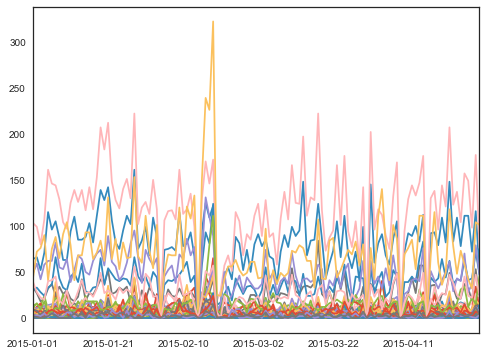

In [35]:
import time
for i in ll:
    var = train_new[train_new['Class'] == i].groupby('SaleDate',as_index=False)['saleCount'].mean()
    figName = str(i) + '.jpg'
    plot_ts_day(var['SaleDate'],var['saleCount'])
#     time.sleep(0.1)
#     print i

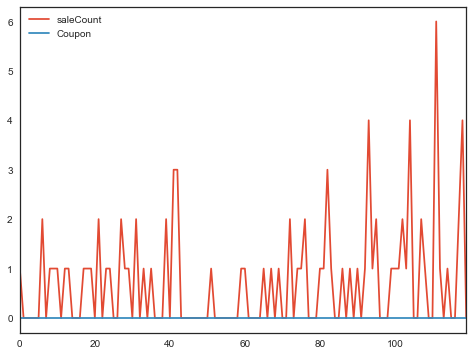

In [10]:
var_1 = train_new[train_new['Class'] == 1101].groupby('SaleDate',as_index=False)['saleCount'].mean()
var_2 = train_new[train_new['Class'] == 1101].groupby('SaleDate',as_index=False)['Coupon'].mean()
var = pd.merge(var_1, var_2 , on= 'SaleDate', how='left')
# var['SaleDate'] = var['SaleDate'].astype('float')
var.plot()
# plt.plot(var)

In [14]:
# plt.plot(train_new.groupby('SaleDate')['saleCount'].mean(), 'o-', label='train_new')
var = train_new[train_new['Class'] == 1501].groupby('SaleDate',as_index=False)['saleCount'].mean()
var.saleCount = var.saleCount.astype('int')
# plt.plot(var)
var

SaleDate  saleCount
0    2015-01-01          1
1    2015-01-02          2
2    2015-01-03          3
3    2015-01-04          2
4    2015-01-05          1
5    2015-01-06          3
6    2015-01-07          6
7    2015-01-08          2
8    2015-01-09          3
9    2015-01-10          1
10   2015-01-11          3
11   2015-01-12          6
12   2015-01-13          0
13   2015-01-14          7
14   2015-01-15          0
15   2015-01-16          2
16   2015-01-17          0
17   2015-01-18          0
18   2015-01-19          3
19   2015-01-20          2
20   2015-01-21          2
21   2015-01-22          5
22   2015-01-23          5
23   2015-01-24          0
24   2015-01-25          2
25   2015-01-26          2
26   2015-01-27          2
27   2015-01-28          3
28   2015-01-29         12
29   2015-01-30          3
..          ...        ...
90   2015-04-01          6
91   2015-04-02          2
92   2015-04-03          2
93   2015-04-04          5
94   2015-04-05          1
95   2015-04-06          0
96   2015-04-07          2
97   2015-04-08          4
98   2015-04-09          0
99   2015-04-10          2
100  2015-04-11          5
101  2015-04-12          2
102  2015-04-13          3
103  2015-04-14          1
104  2015-04-15          3
105  2015-04-16          0
106  2015-04-17          2
107  2015-04-18          0
108  2015-04-19          5
109  2015-04-20          5
110  2015-04-21          5
111  2015-04-22          3
112  2015-04-23          3
113  2015-04-24          2
114  2015-04-25          0
115  2015-04-26          5
116  2015-04-27          4
117  2015-04-28          5
118  2015-04-29          5
119  2015-04-30          2

[120 rows x 2 columns]

## 有过促销的商品

In [6]:
c = train_new.groupby('Class',as_index=False)['Coupon'].sum()
c[c['Coupon'] != 0.0]['Class'].unique()

array([  15,   20,   21,   22,   23,   30,   31,   32,   33,   34, 1501,
       1502, 1503, 1505, 1508, 1509, 1510, 1512, 1513, 1515, 1517, 1518,
       1519, 1521, 2001, 2002, 2003, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2101, 2103, 2104, 2105, 2106, 2107,
       2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211,
       2212, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2309, 2310, 2311,
       2314, 2315, 2317, 3001, 3002, 3003, 3004, 3006, 3007, 3008, 3009,
       3010, 3011, 3013, 3016, 3018, 3107, 3109, 3110, 3111, 3112, 3113,
       3114, 3115, 3116, 3117, 3118, 3119, 3122, 3126, 3213, 3216, 3301,
       3314, 3319, 3320, 3330, 3402, 3403, 3406, 3407, 3408, 3409, 3410,
       3412, 3415, 3419, 3423, 3424, 3426, 3428, 3429, 3431], dtype=int64)

## 没有促销的商品

In [7]:
c = train_new.groupby('Class',as_index=False)['Coupon'].sum()
c[c['Coupon'] == 0.0]['Class'].unique()

array([  10,   11,   12,   13,   14, 1001, 1002, 1004, 1005, 1006, 1007,
       1099, 1101, 1102, 1103, 1104, 1201, 1202, 1203, 1205, 1301, 1302,
       1306, 1308, 1402, 1403, 1504, 1511, 1514, 1516, 2004, 2102, 2108,
       2308, 2312, 2313, 2316, 3005, 3012, 3014, 3015, 3017, 3101, 3102,
       3104, 3105, 3106, 3108, 3120, 3121, 3125, 3128, 3212, 3215, 3217,
       3218, 3227, 3303, 3313, 3315, 3316, 3321, 3322, 3323, 3325, 3326,
       3328, 3401, 3404, 3416, 3417, 3427, 3432, 3436], dtype=int64)

## 测试集中有过促销的商品

In [8]:
ct = [f for f in ll if f in c[c['Coupon'] != 0.0]['Class'].unique()]
print len(ct)
ct

101


[1501,
 1502,
 1503,
 1505,
 1508,
 1510,
 1512,
 1513,
 1515,
 1517,
 1518,
 1519,
 1521,
 2001,
 2002,
 2003,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2101,
 2103,
 2104,
 2105,
 2106,
 2107,
 2201,
 2202,
 2203,
 2204,
 2205,
 2206,
 2207,
 2208,
 2209,
 2210,
 2211,
 2212,
 2301,
 2302,
 2303,
 2304,
 2305,
 2306,
 2307,
 2309,
 2310,
 2311,
 2314,
 2317,
 3001,
 3002,
 3003,
 3004,
 3006,
 3007,
 3008,
 3010,
 3011,
 3013,
 3016,
 3018,
 3107,
 3109,
 3110,
 3112,
 3113,
 3114,
 3116,
 3117,
 3118,
 3119,
 3126,
 3319,
 3320,
 3402,
 3403,
 3407,
 3408,
 3415,
 3423,
 3424,
 3426,
 3431,
 15,
 20,
 21,
 22,
 23,
 30,
 31,
 32,
 33,
 34]

## 测试集中没有过促销的商品

In [9]:
nct = [f for f in ll if f in c[c['Coupon'] == 0.0]['Class'].unique()]
print len(nct)
nct

43


[1001,
 1002,
 1004,
 1005,
 1099,
 1101,
 1102,
 1103,
 1201,
 1202,
 1203,
 1205,
 1301,
 1302,
 1306,
 1308,
 1504,
 1511,
 1516,
 2004,
 2102,
 2312,
 2313,
 2316,
 3005,
 3014,
 3017,
 3102,
 3105,
 3125,
 3217,
 3227,
 3316,
 3321,
 3322,
 3323,
 3325,
 3326,
 3417,
 10,
 11,
 12,
 13]

In [131]:
from sklearn.preprocessing import StandardScaler
StandardScaler().fit_transform(var_1['saleCount']) 

array([-0.78997697, -0.29104415, -0.12473321, -0.45735509,  0.20788868,
       -0.45735509,  3.36779657, -0.12473321, -0.62366603, -0.62366603,
       -0.78997697,  0.7068215 , -0.45735509,  1.37206527,  0.20788868,
        0.20788868, -0.78997697, -0.45735509, -0.62366603,  0.20788868,
        2.86886374, -0.29104415, -0.12473321, -0.95628791, -0.45735509,
        0.87313244,  0.7068215 ,  4.53197316,  0.20788868, -0.62366603,
       -0.29104415, -0.45735509, -0.45735509,  0.20788868, -1.2889098 ,
        0.37419962, -0.62366603, -1.12259886,  0.37419962,  0.04157774,
        1.03944338,  2.86886374, -0.29104415, -0.29104415, -1.2889098 ,
        1.20575433,  0.20788868,  1.37206527,  0.20788868, -1.12259886,
       -1.2889098 , -0.95628791, -0.62366603, -0.95628791, -1.12259886,
       -1.2889098 , -0.95628791, -0.78997697, -0.62366603,  0.04157774,
        0.20788868,  0.04157774,  0.7068215 ,  0.20788868, -0.78997697,
       -0.45735509, -0.45735509,  0.87313244, -0.45735509,  0.37

In [136]:
ct

[1501,
 1502,
 1503,
 1505,
 1508,
 1510,
 1512,
 1513,
 1515,
 1517,
 1518,
 1519,
 1521,
 2001,
 2002,
 2003,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2101,
 2103,
 2104,
 2105,
 2106,
 2107,
 2201,
 2202,
 2203,
 2204,
 2205,
 2206,
 2207,
 2208,
 2209,
 2210,
 2211,
 2212,
 2301,
 2302,
 2303,
 2304,
 2305,
 2306,
 2307,
 2309,
 2310,
 2311,
 2314,
 2317,
 3001,
 3002,
 3003,
 3004,
 3006,
 3007,
 3008,
 3010,
 3011,
 3013,
 3016,
 3018,
 3107,
 3109,
 3110,
 3112,
 3113,
 3114,
 3116,
 3117,
 3118,
 3119,
 3126,
 3319,
 3320,
 3402,
 3403,
 3407,
 3408,
 3415,
 3423,
 3424,
 3426,
 3431,
 15,
 20,
 21,
 22,
 23,
 30,
 31,
 32,
 33,
 34]

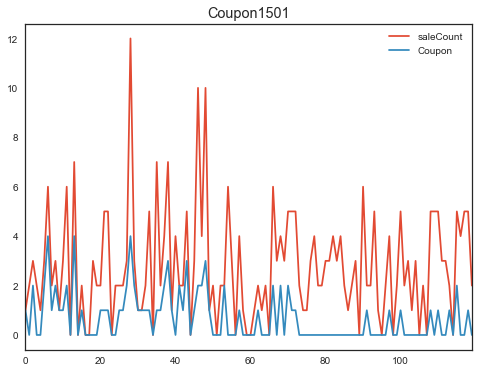

In [15]:
path= 'class_pics/coupon/'
className = 1501
var_1 = train_new[train_new['Class'] == className].groupby('SaleDate',as_index=False)['saleCount'].mean()
var_2 = train_new[train_new['Class'] == className].groupby('SaleDate',as_index=False)['Coupon'].mean()
var = pd.merge(var_1, var_2 , on= 'SaleDate', how='left')
# var['SaleDate'] = var['SaleDate'].astype('float')
var.plot(title= 'Coupon' + str(className))
fileName = path + str(className) + '.jpg'
plt.savefig(fileName)
# plt.plot(var)

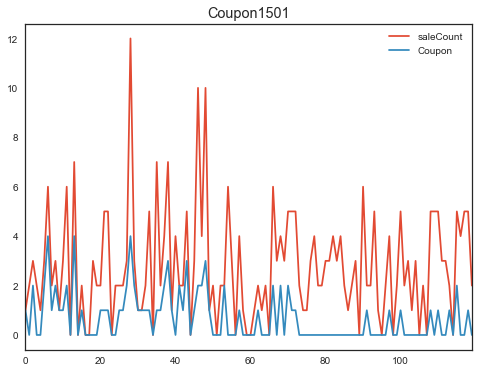

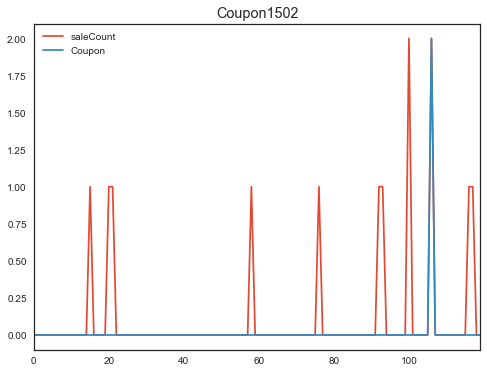

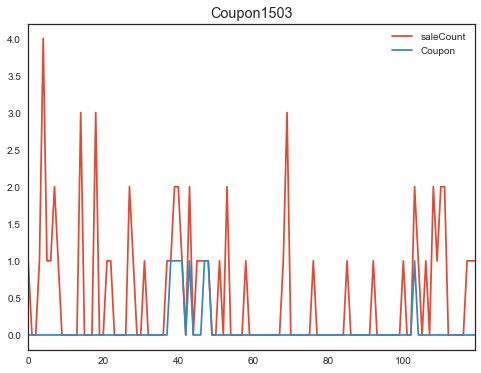

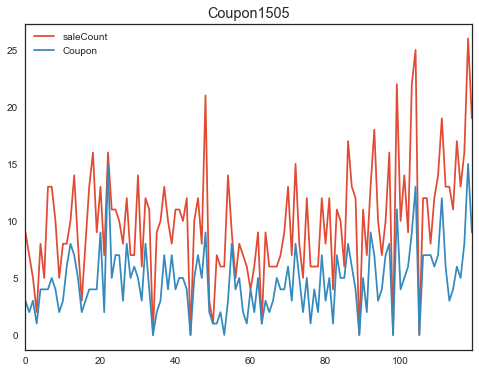

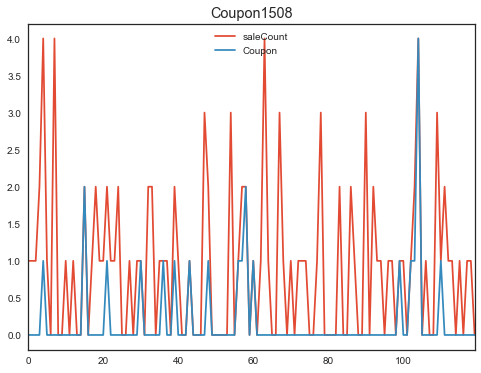

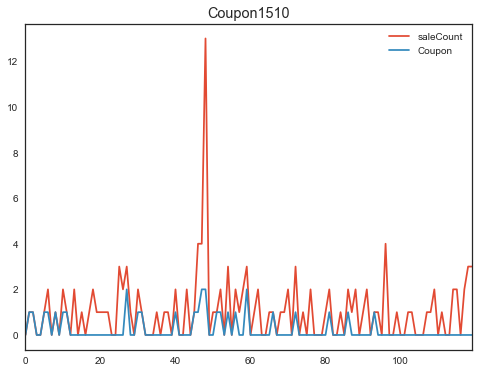

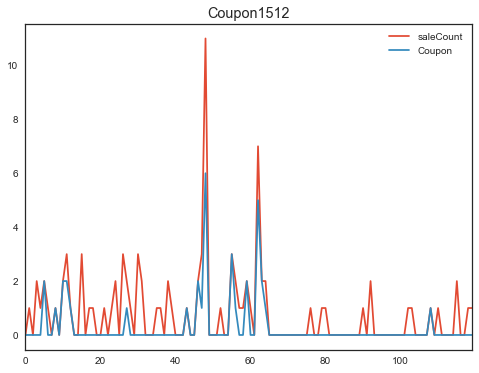

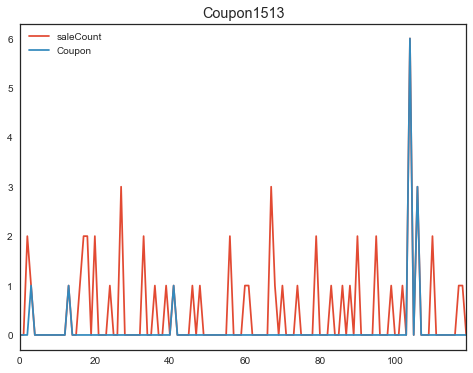

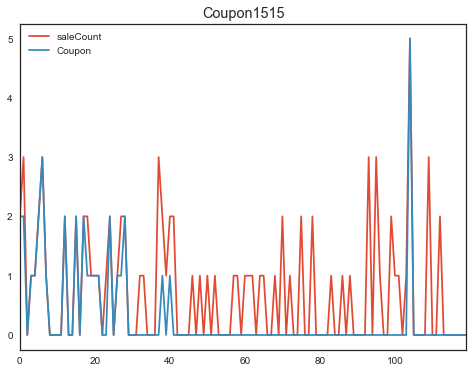

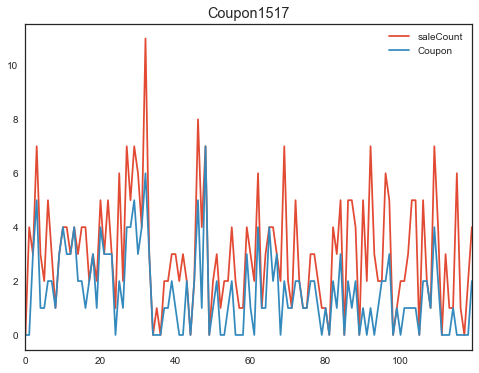

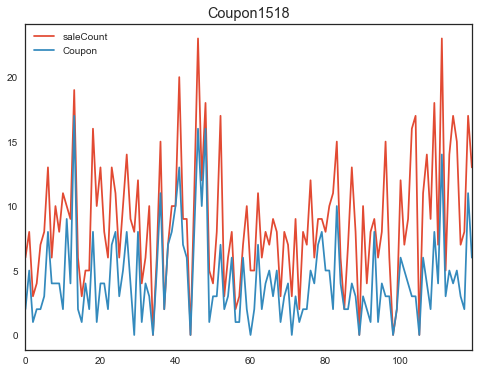

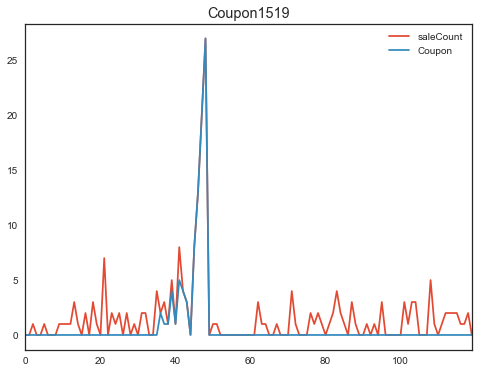

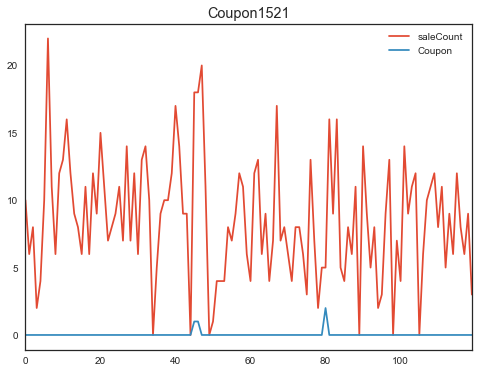

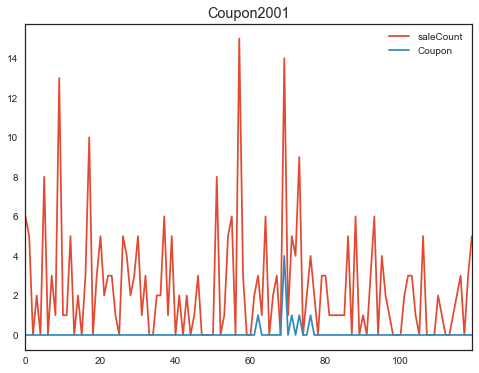

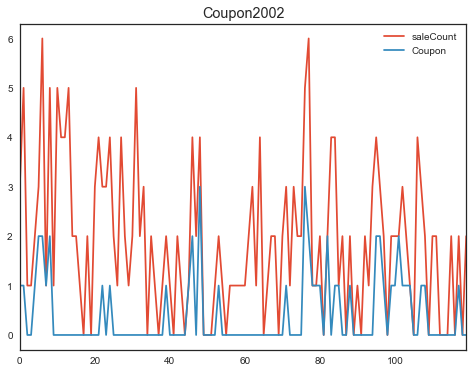

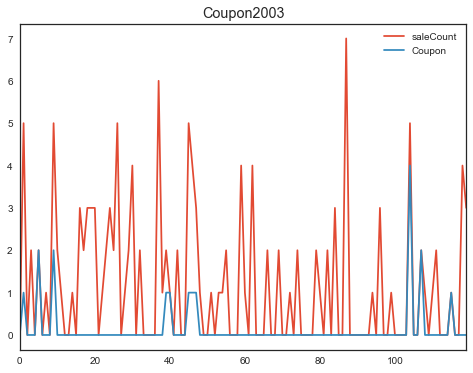

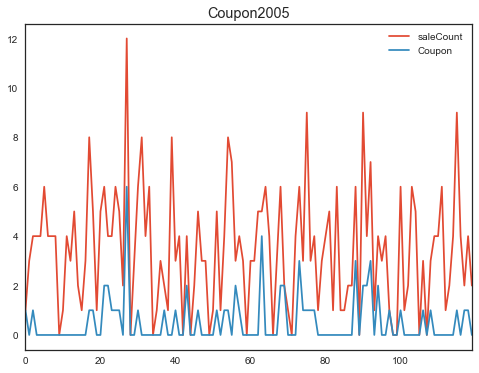

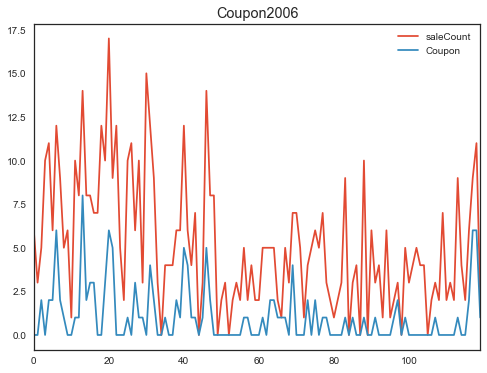

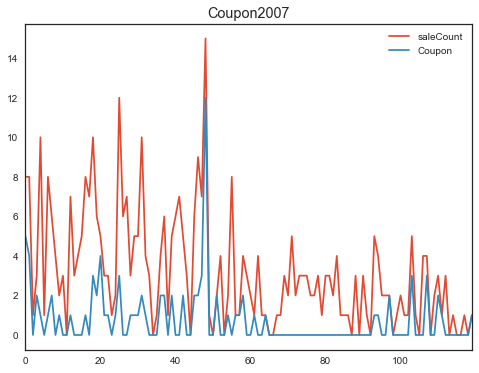

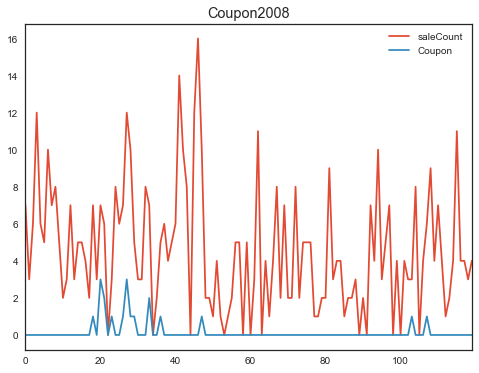

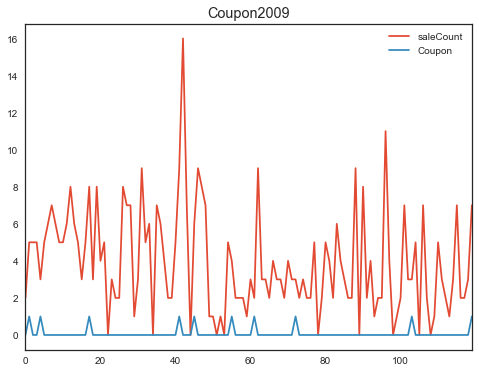

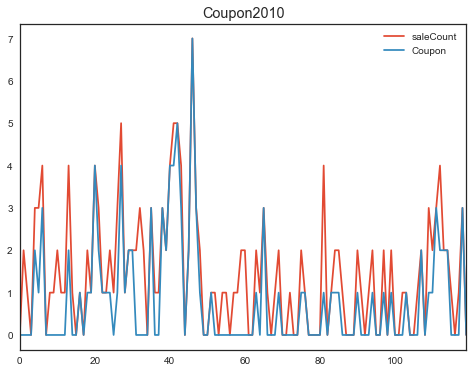

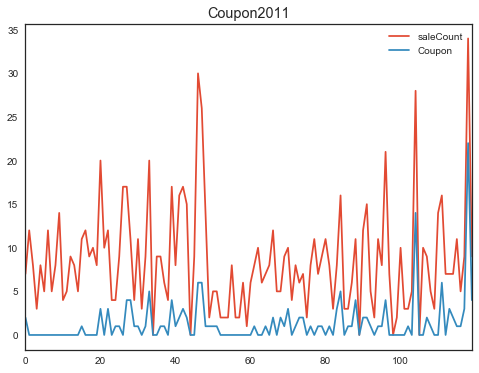

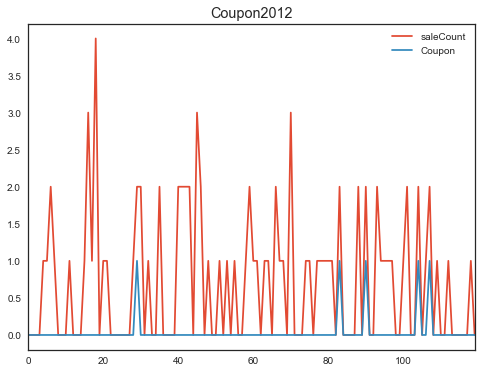

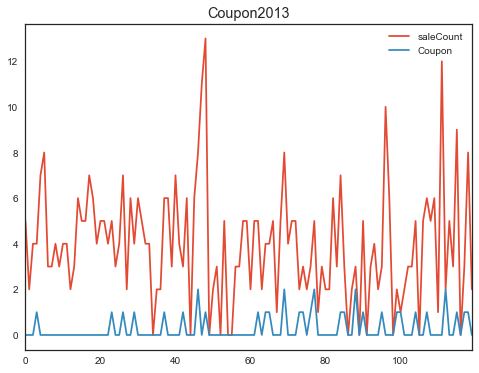

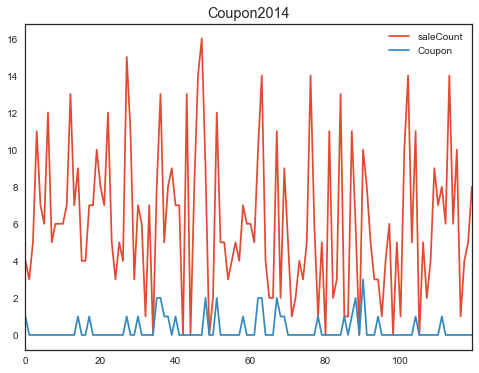

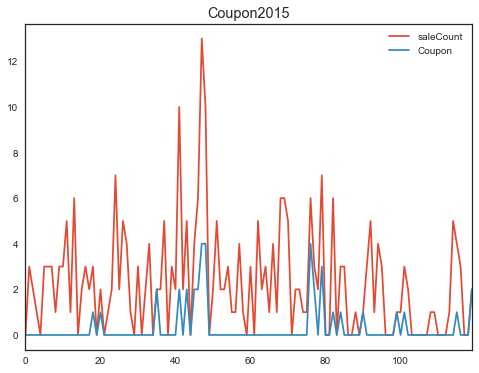

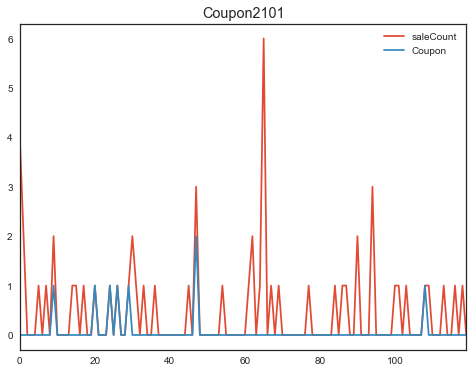

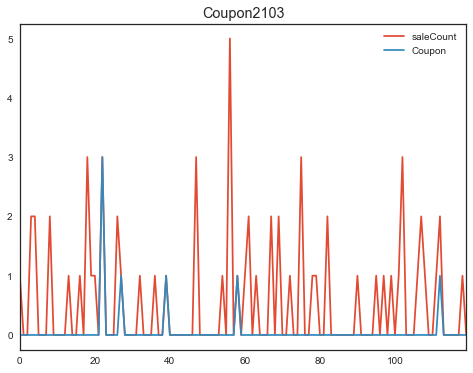

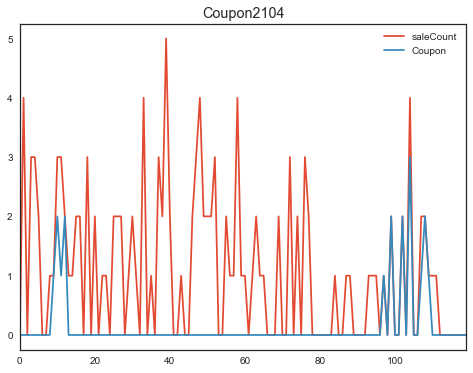

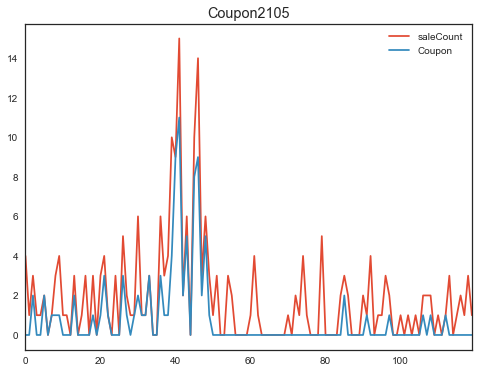

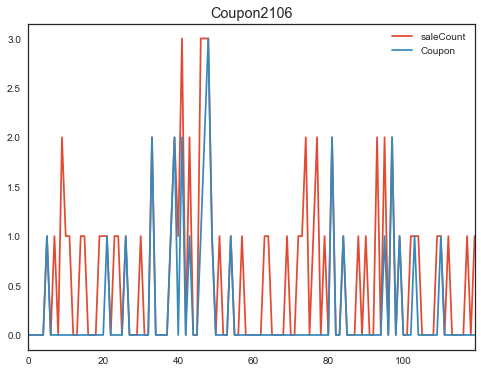

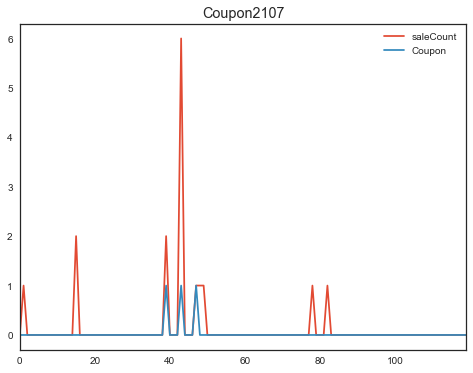

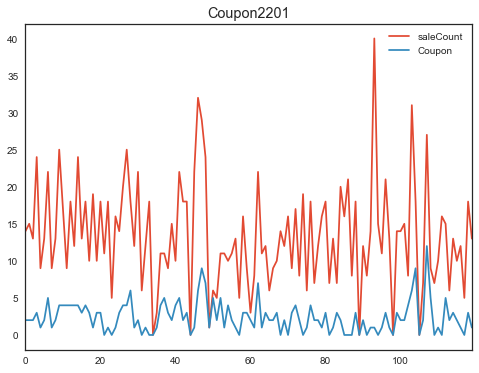

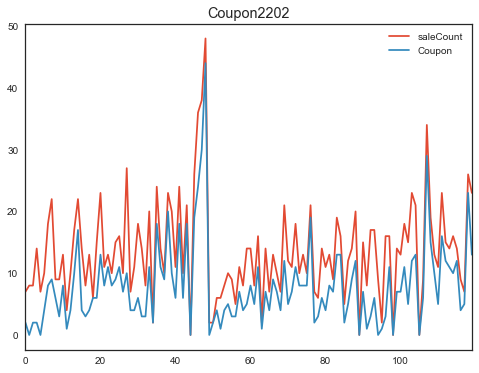

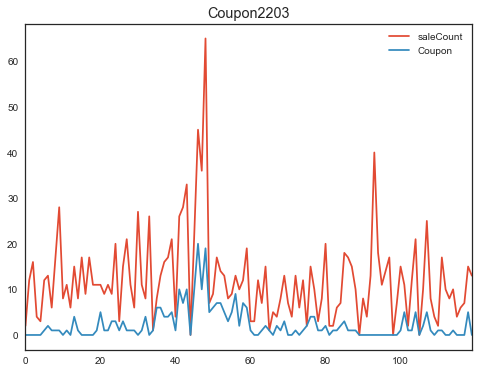

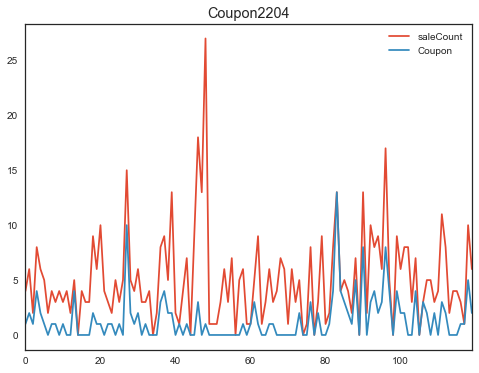

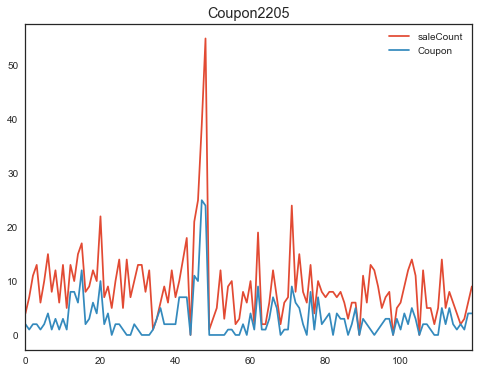

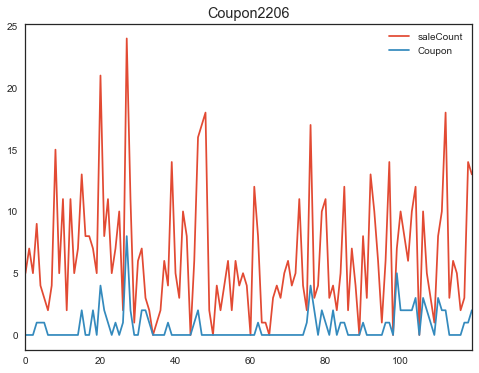

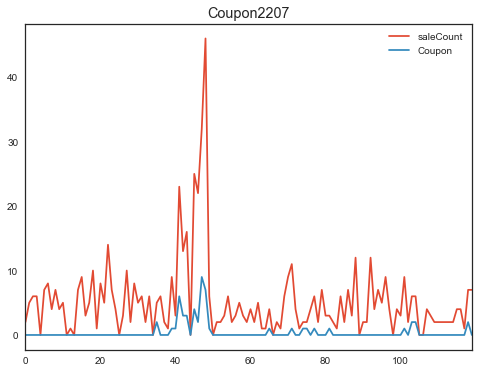

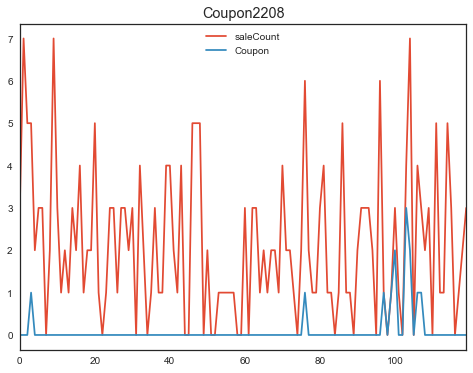

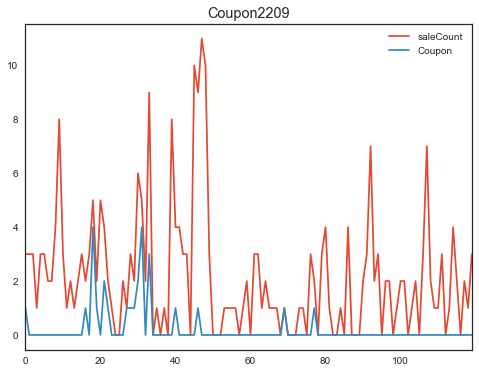

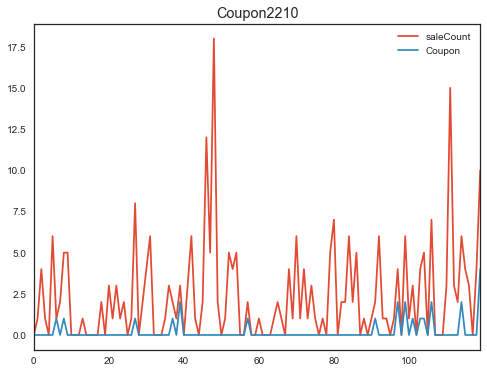

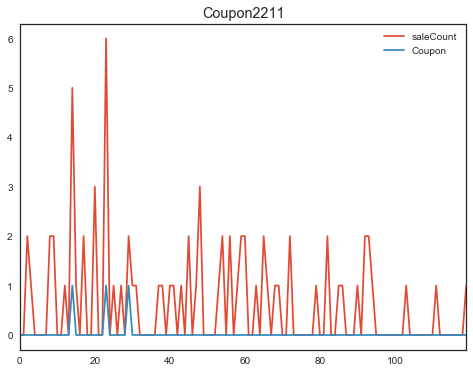

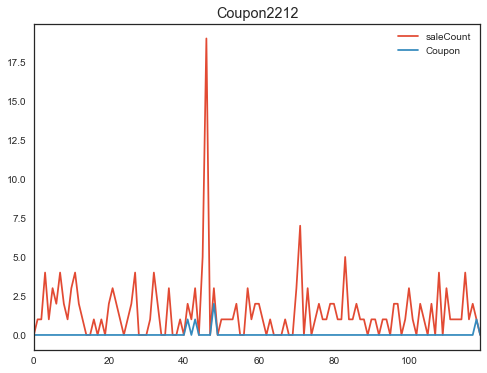

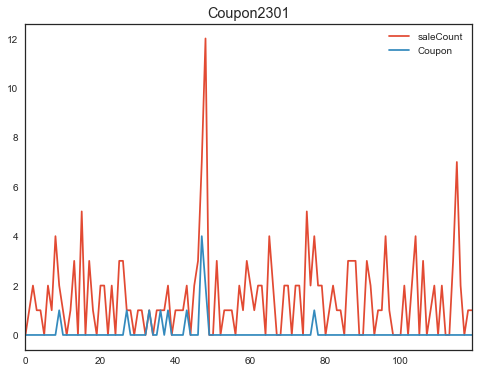

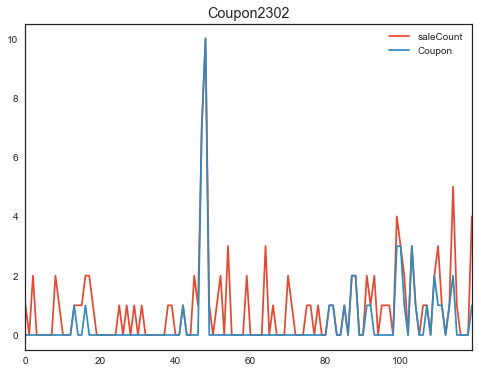

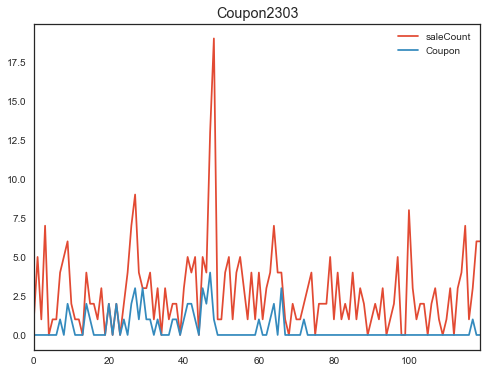

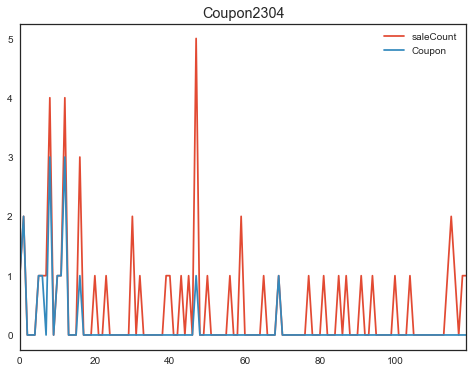

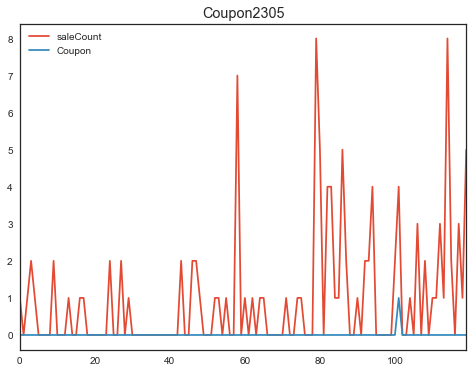

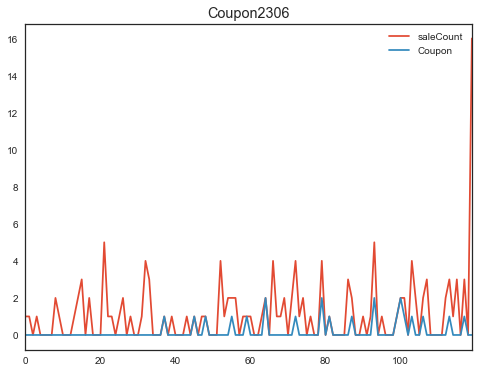

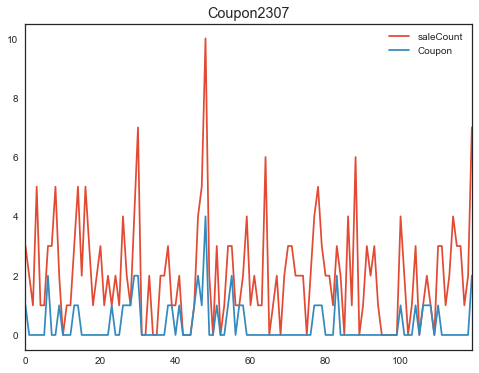

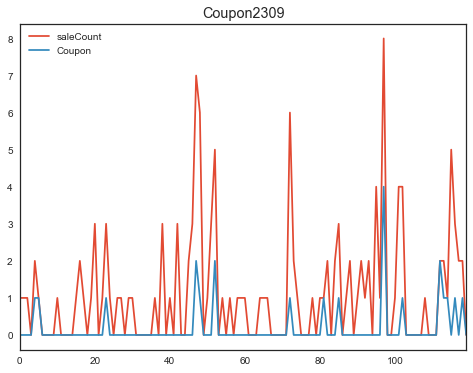

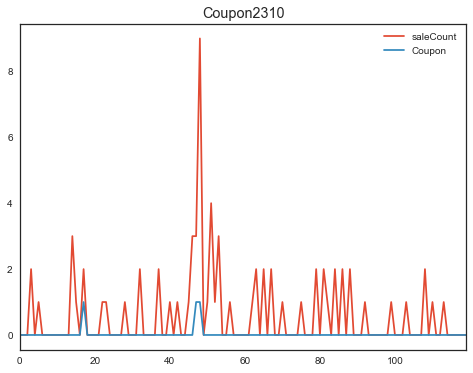

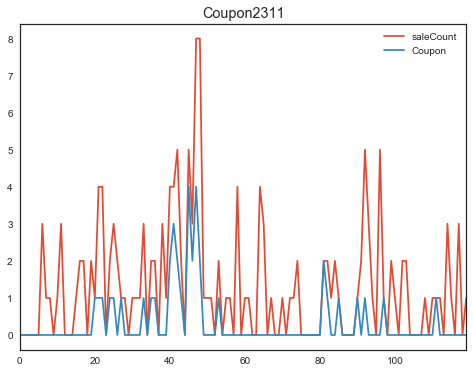

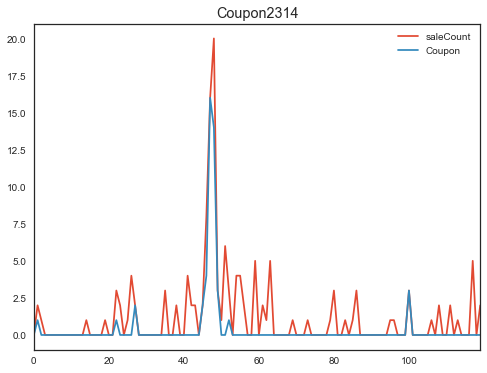

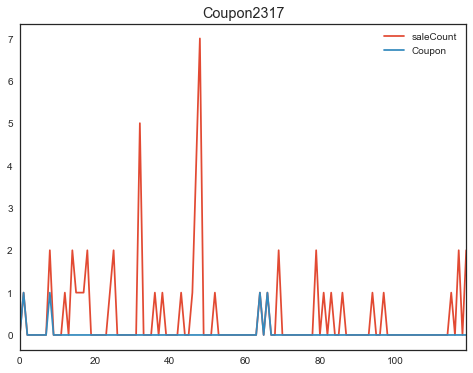

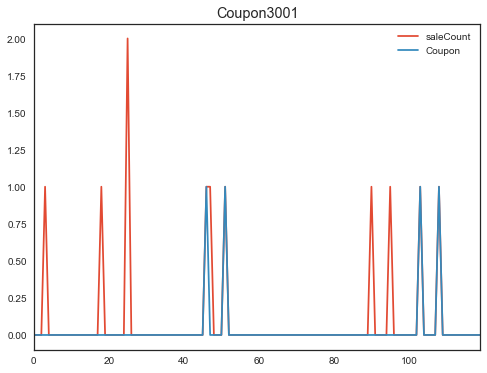

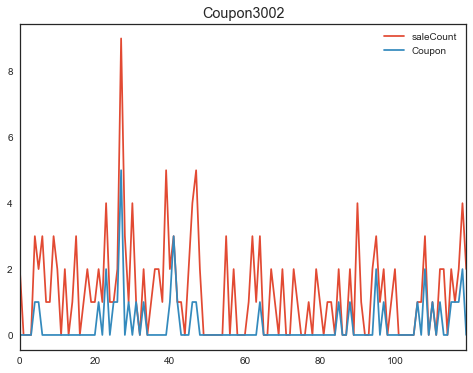

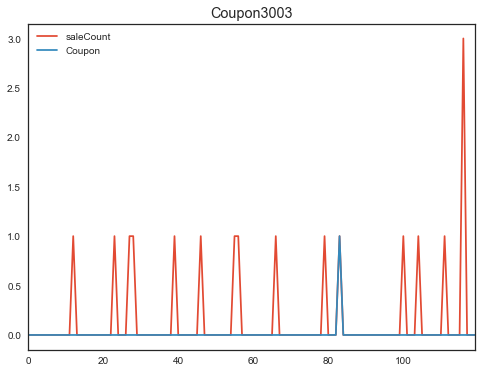

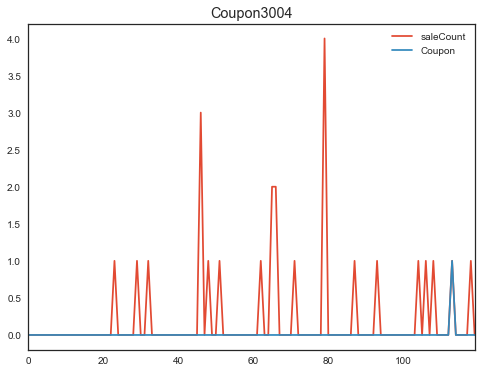

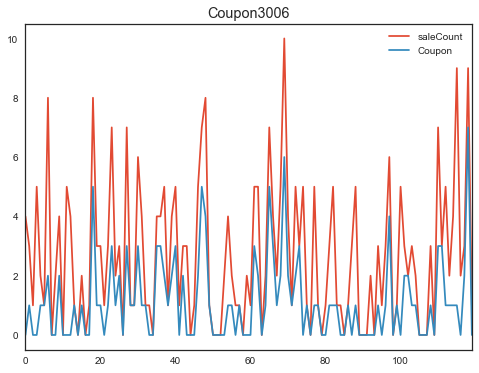

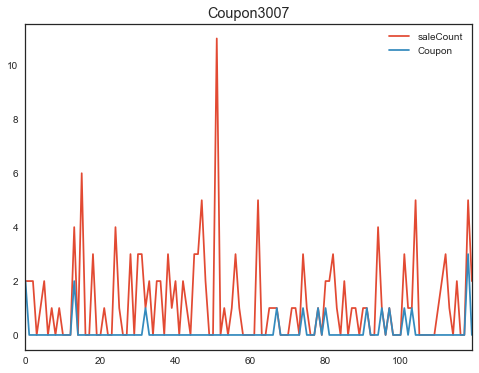

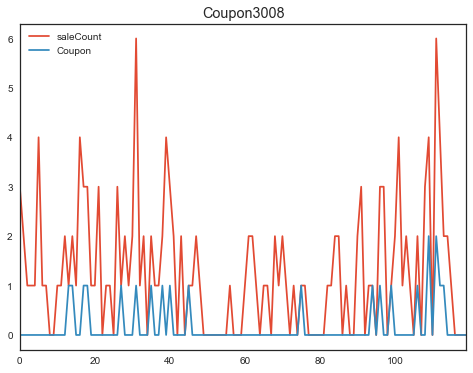

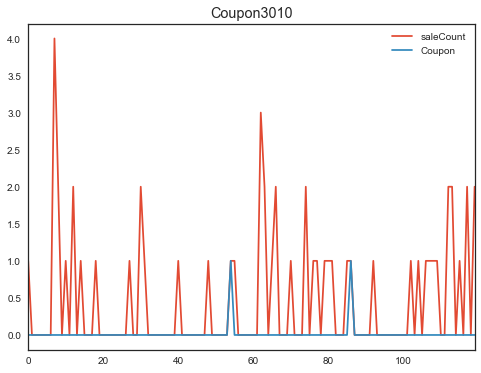

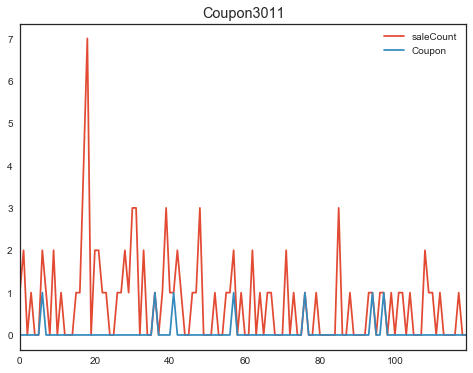

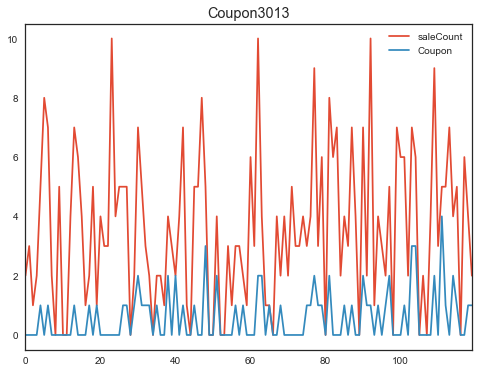

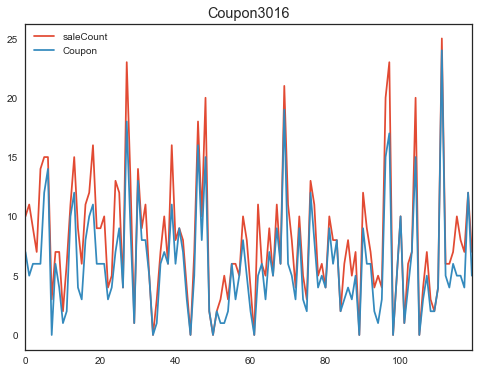

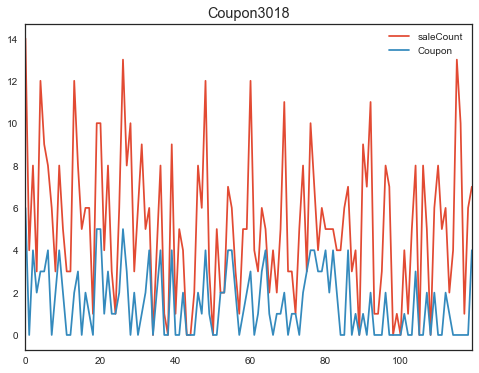

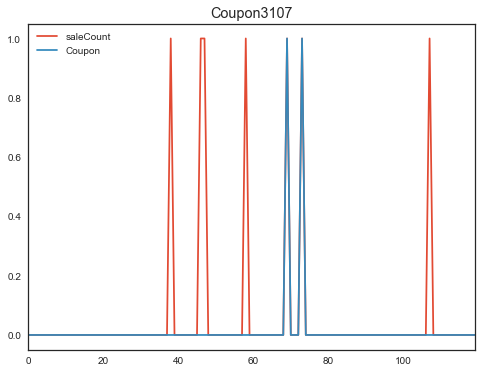

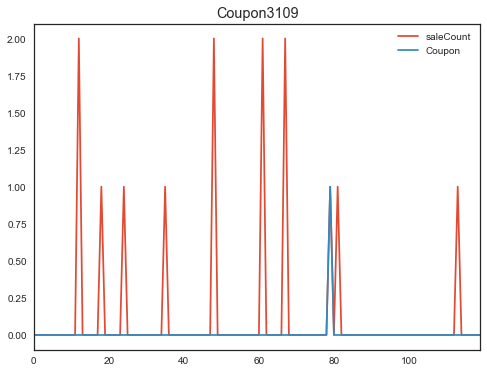

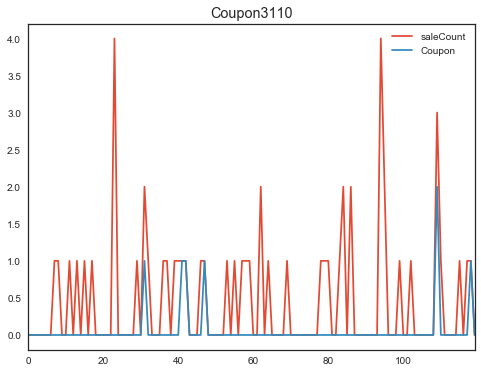

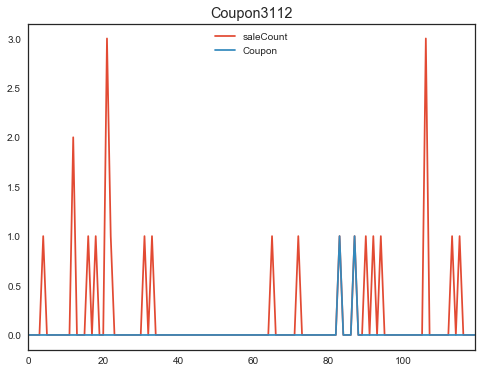

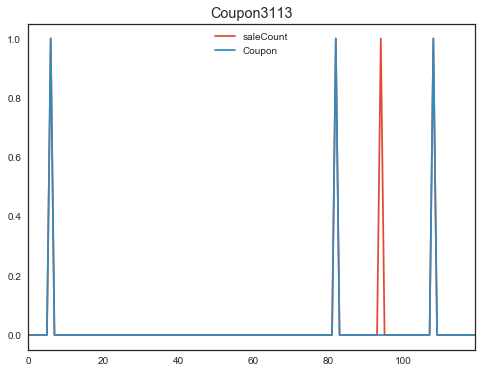

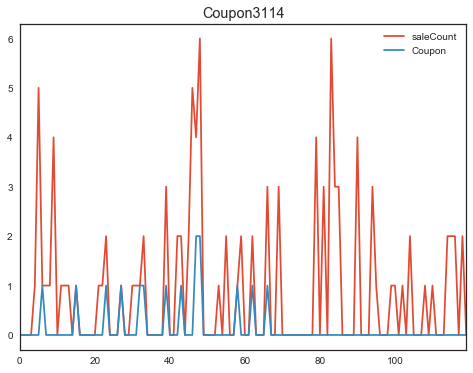

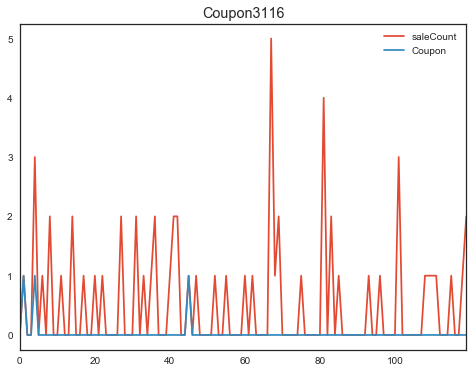

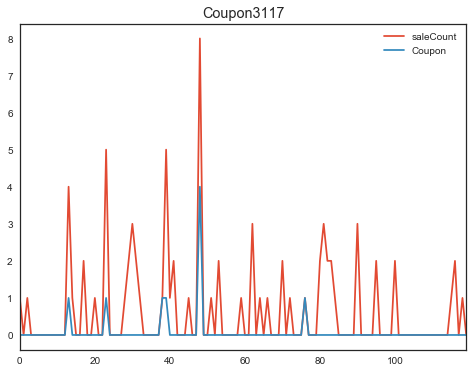

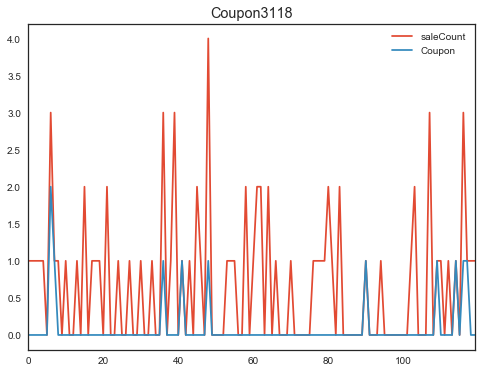

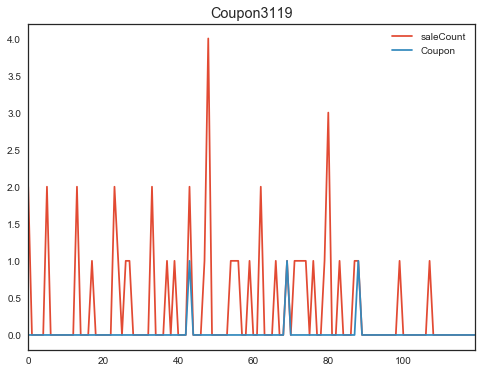

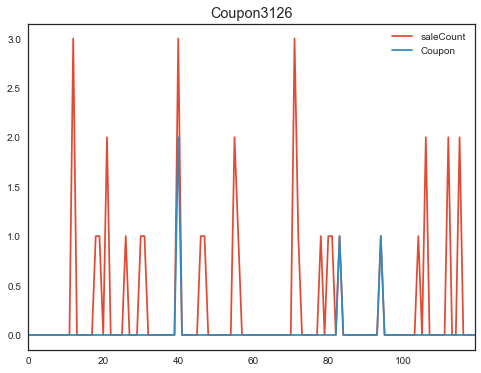

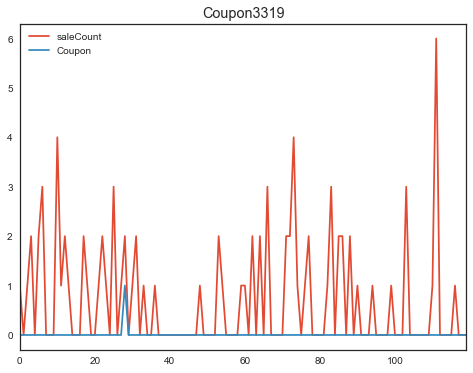

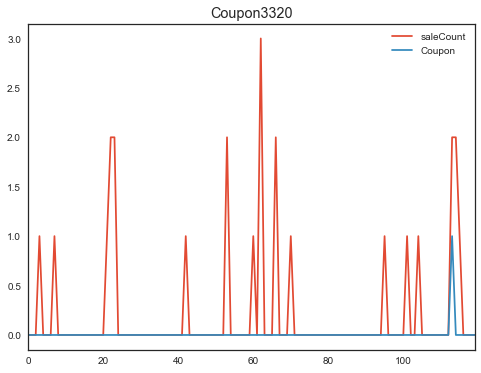

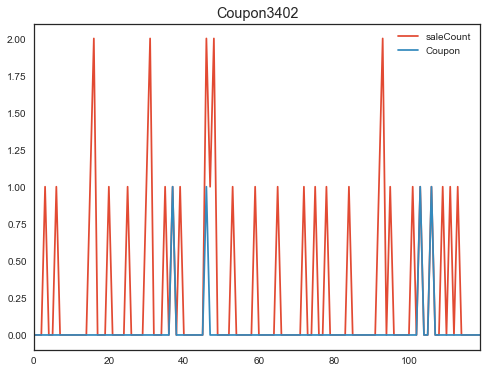

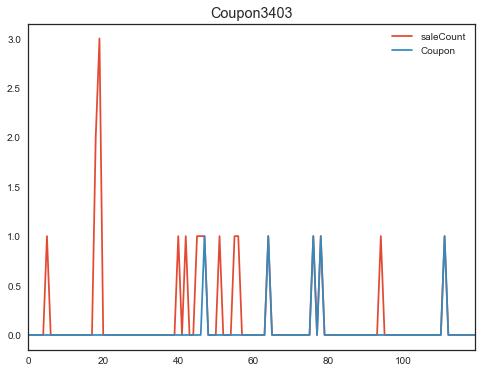

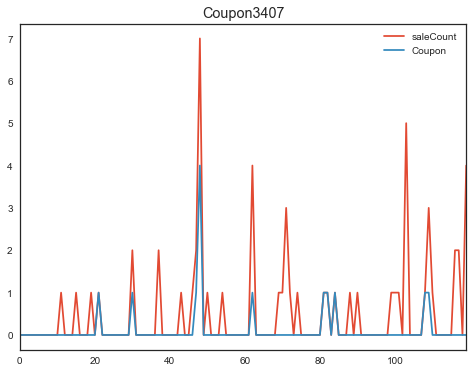

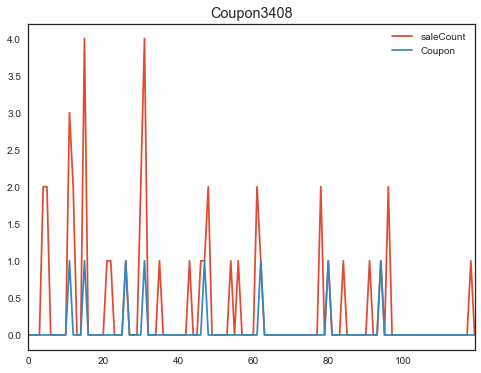

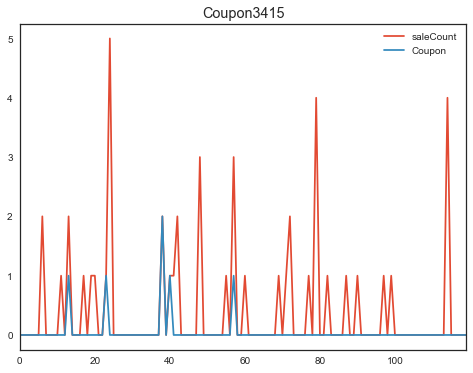

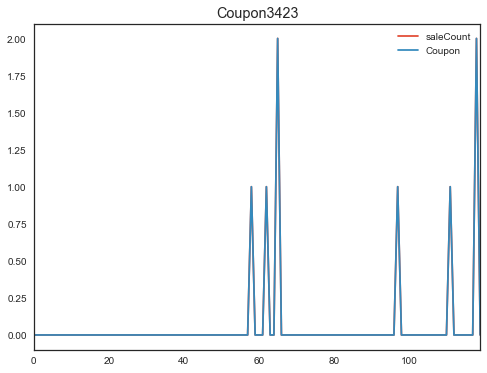

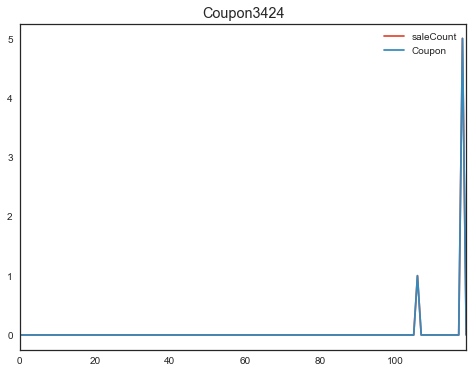

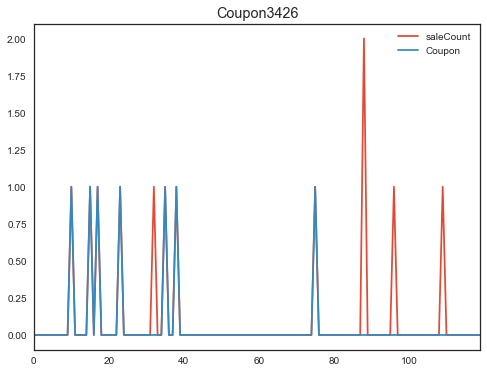

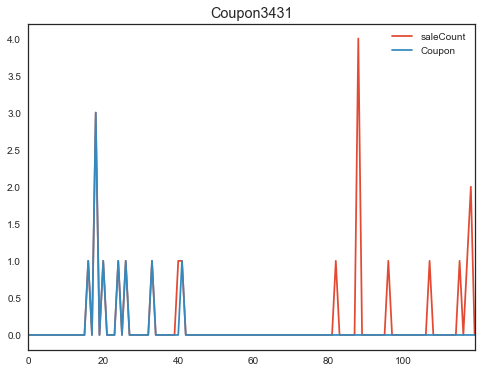

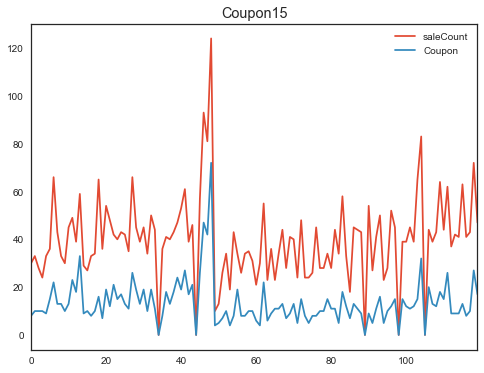

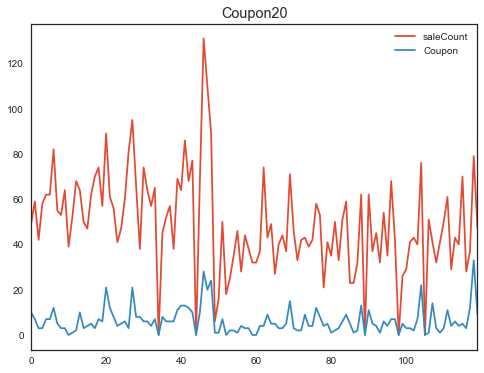

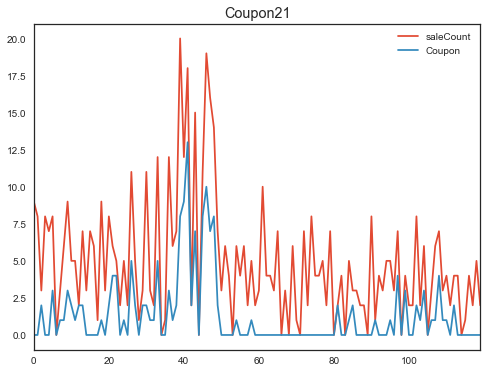

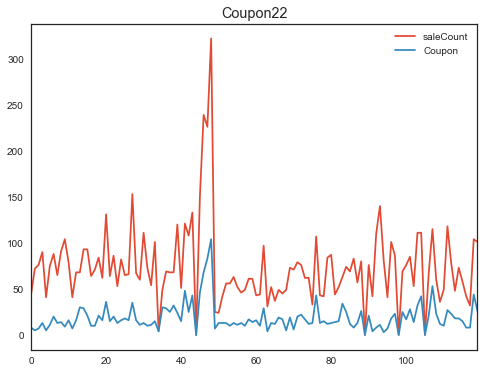

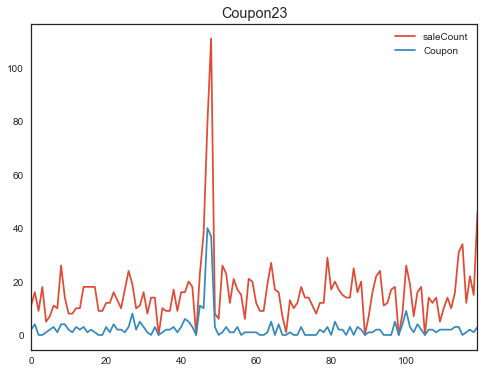

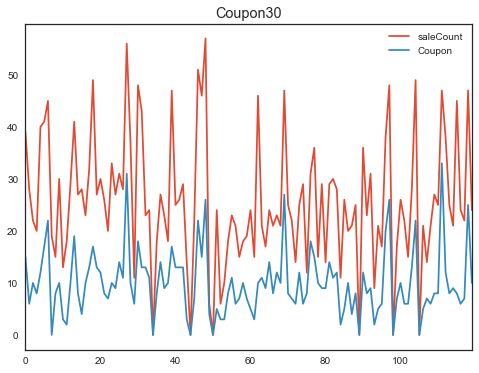

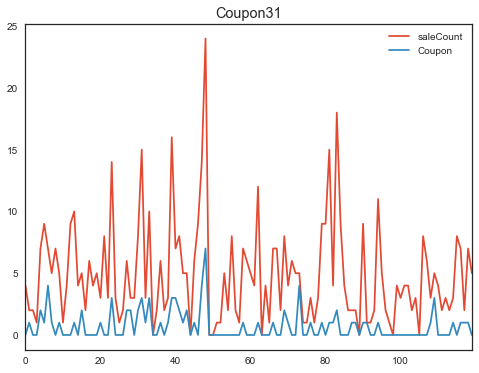

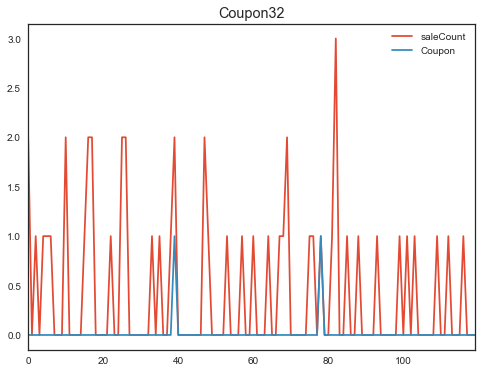

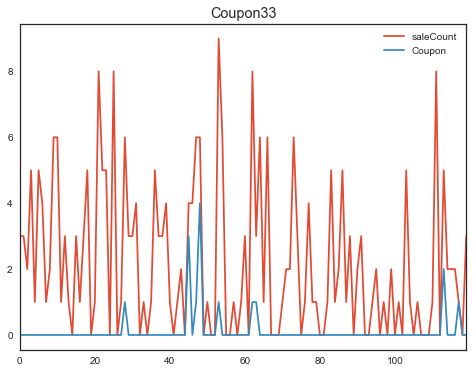

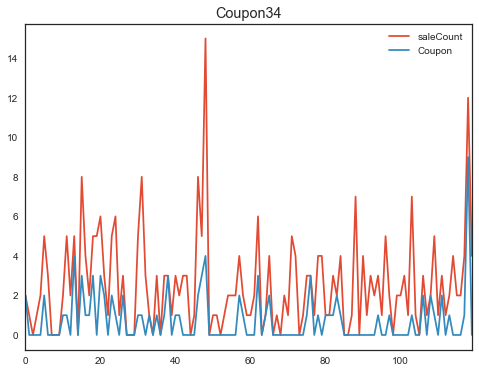

In [149]:
import time
path= 'class_pics/coupon/'
for i in ct:  
    className = i
    var_1 = train_new[train_new['Class'] == className].groupby('SaleDate',as_index=False)['saleCount'].mean()
    var_2 = train_new[train_new['Class'] == className].groupby('SaleDate',as_index=False)['Coupon'].mean()
    var = pd.merge(var_1, var_2 , on= 'SaleDate', how='left')
    # var['SaleDate'] = var['SaleDate'].astype('float')
    var.plot(title= 'Coupon' + str(className))
    fileName = path + str(className) + '.jpg'
    plt.savefig(fileName)
#     var.colse(fileName)
#     _.get_figure().clear()
#     pylab.colse()
    time.sleep(1)

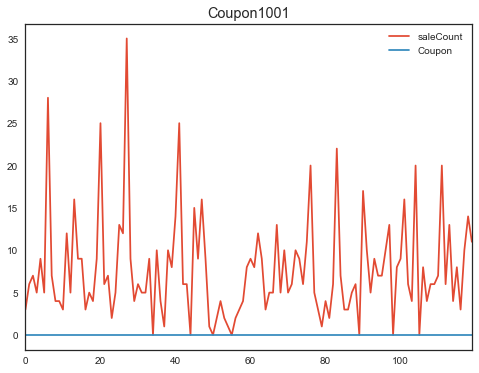

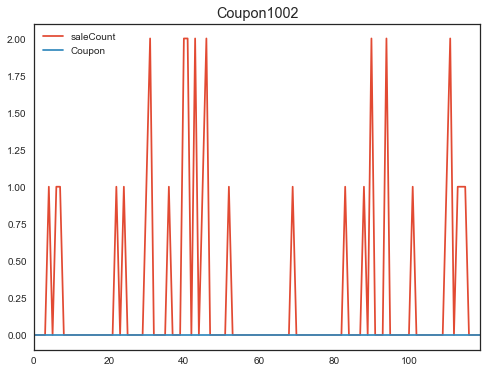

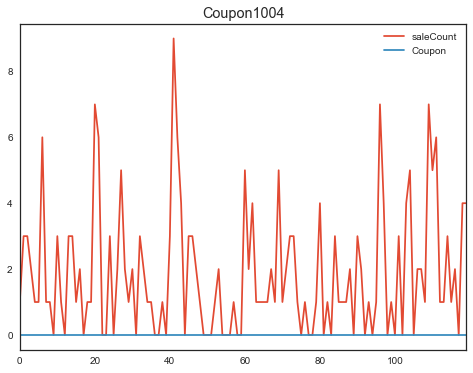

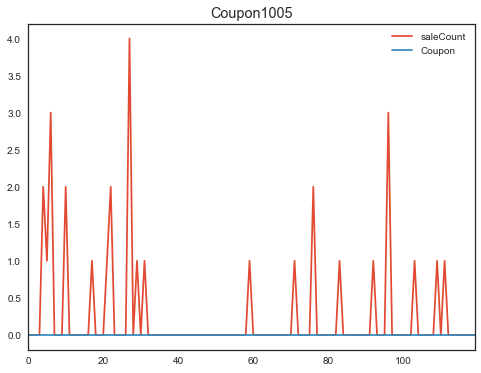

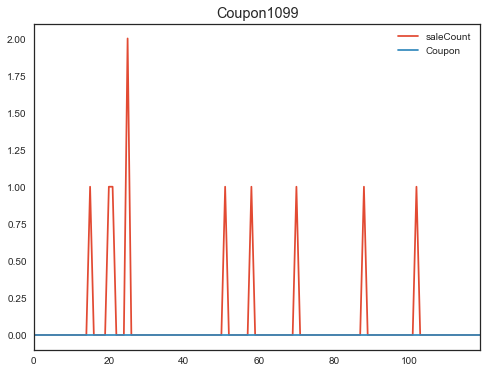

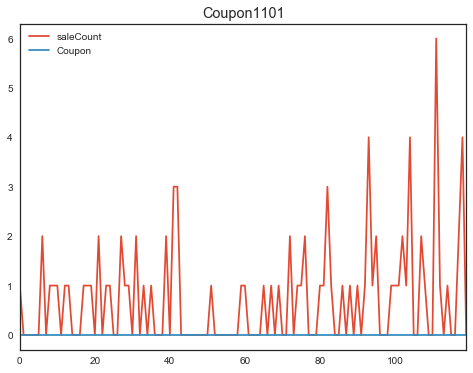

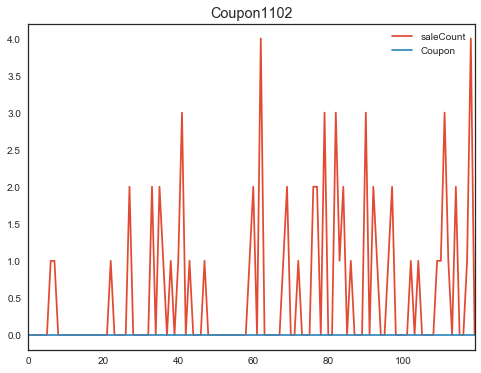

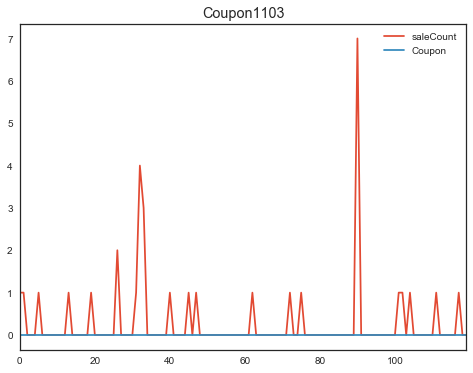

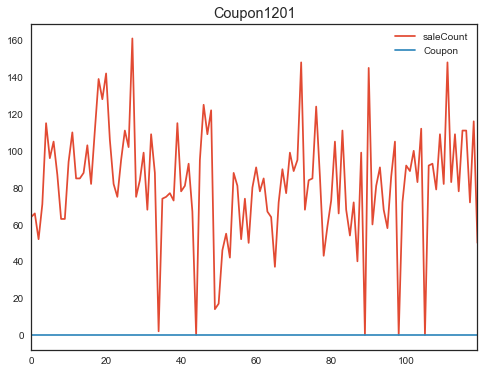

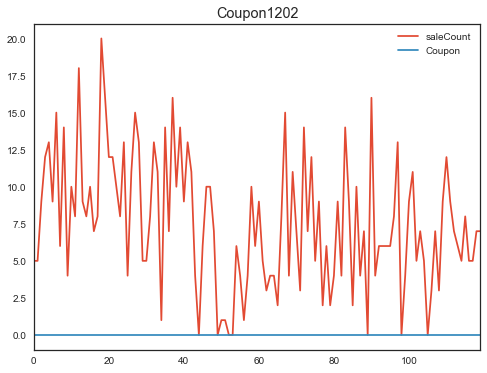

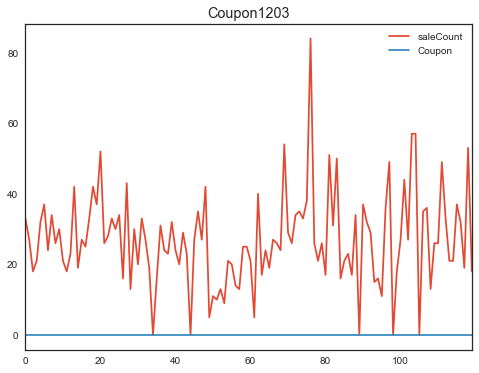

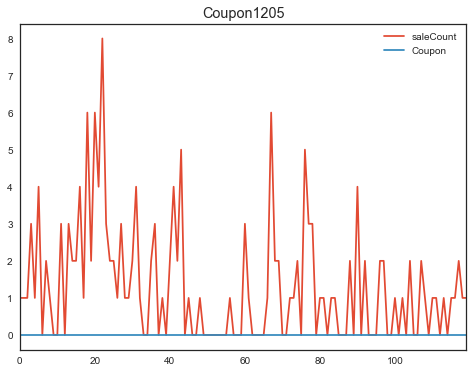

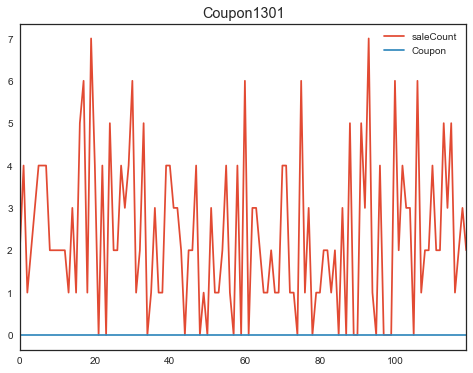

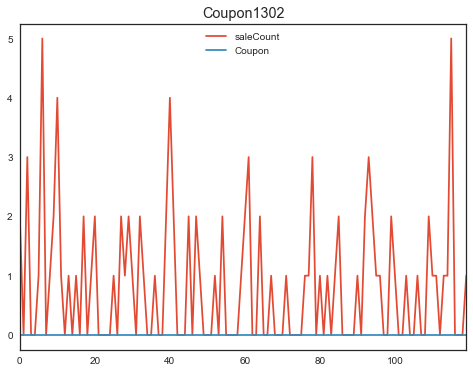

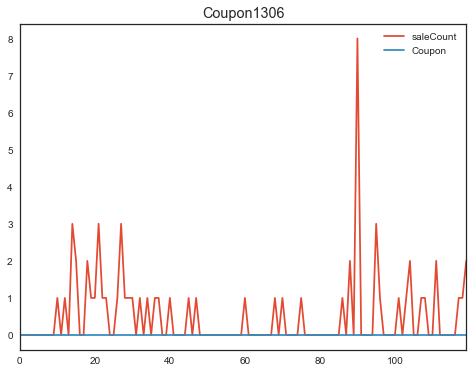

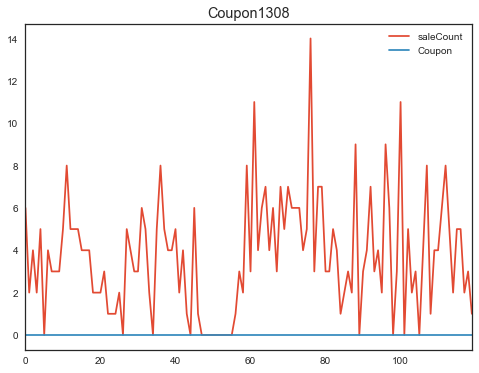

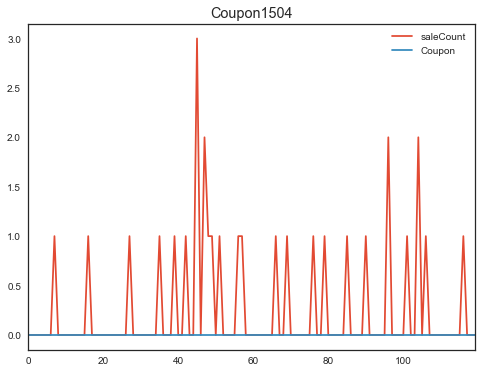

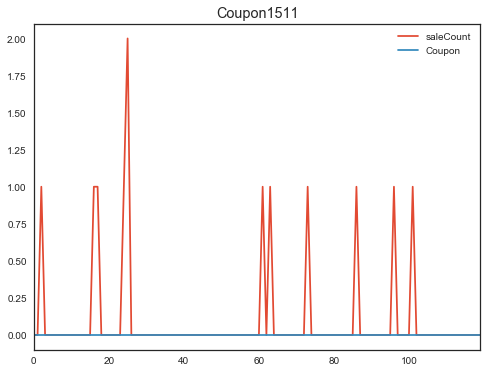

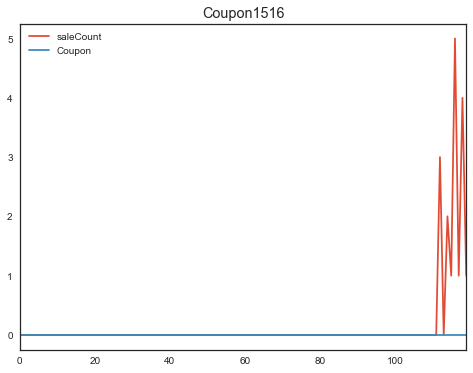

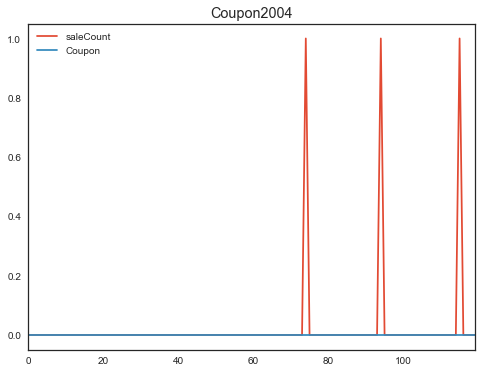

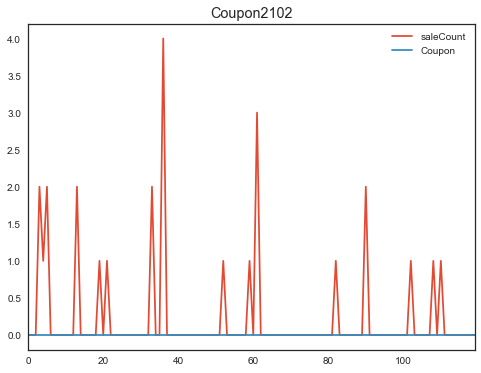

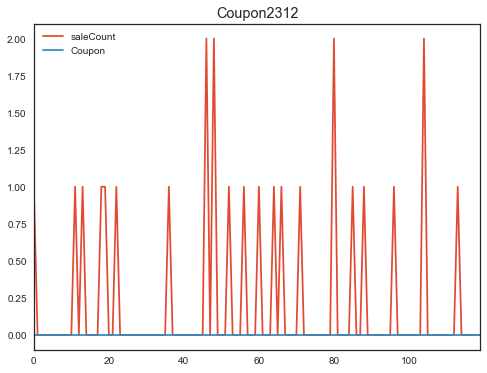

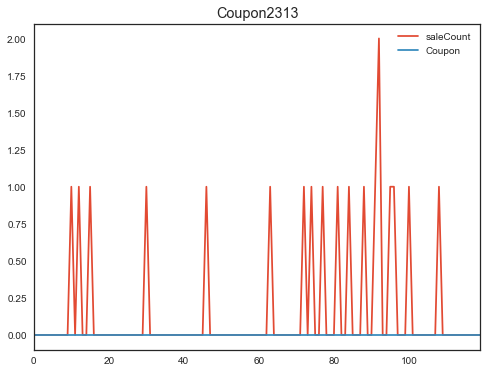

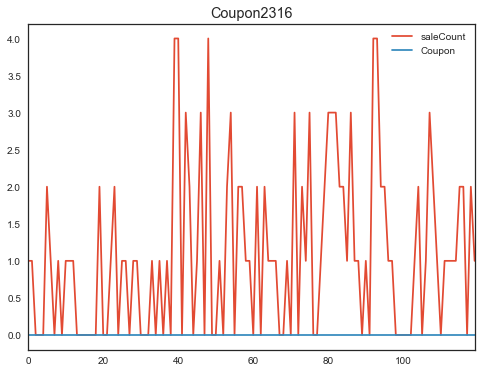

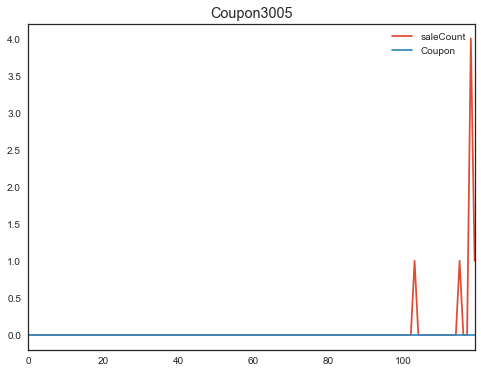

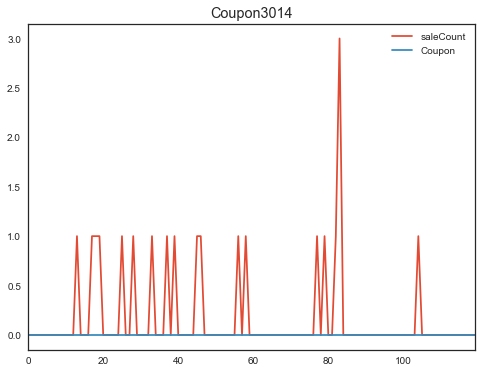

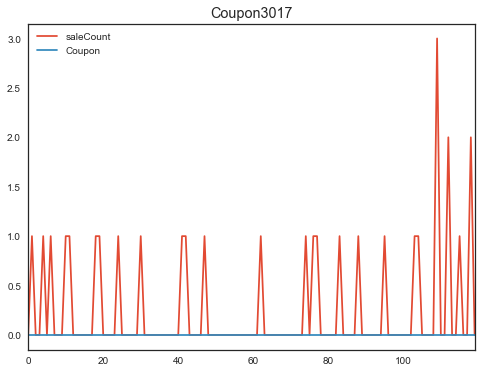

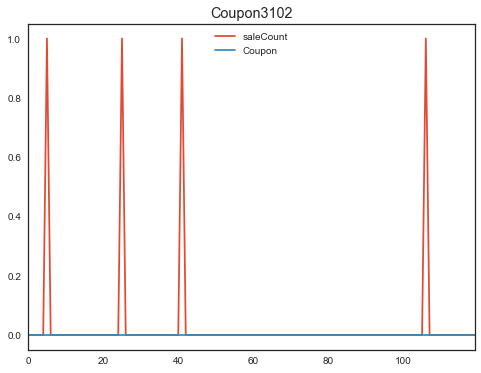

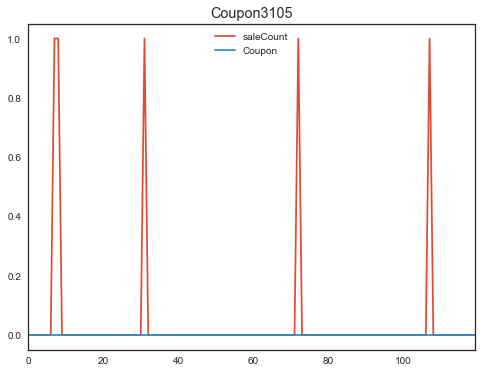

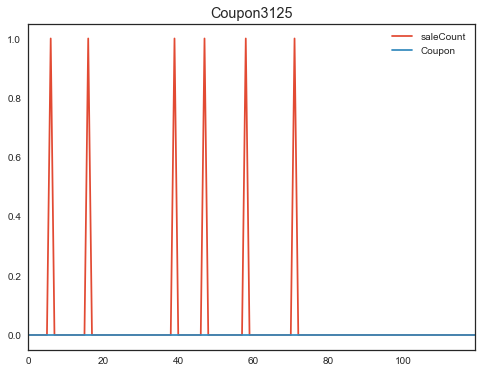

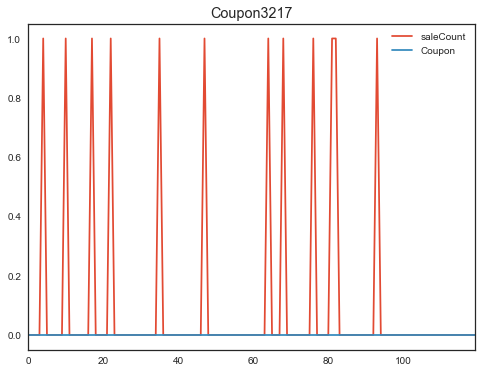

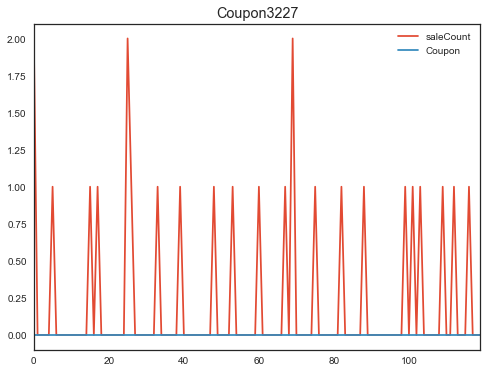

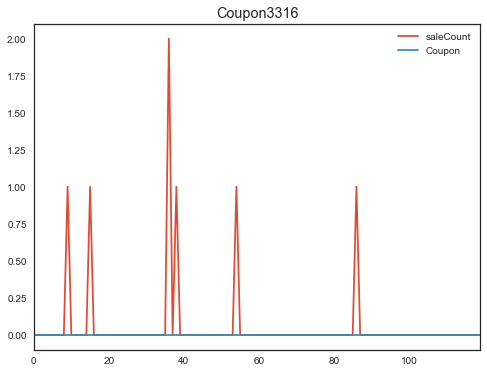

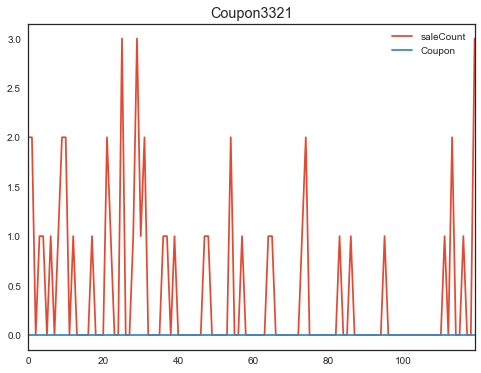

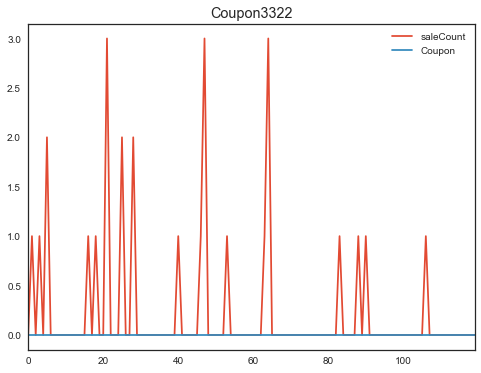

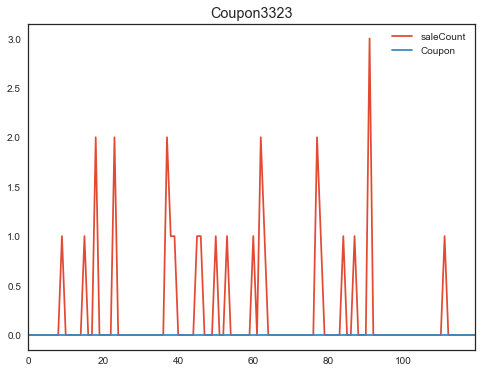

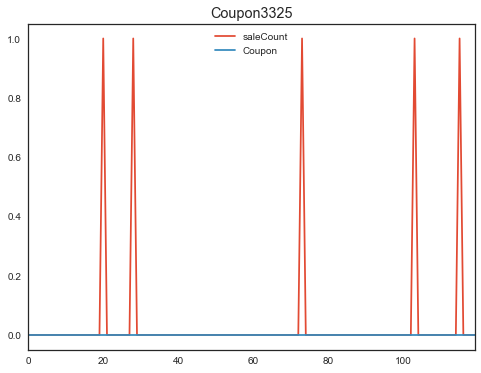

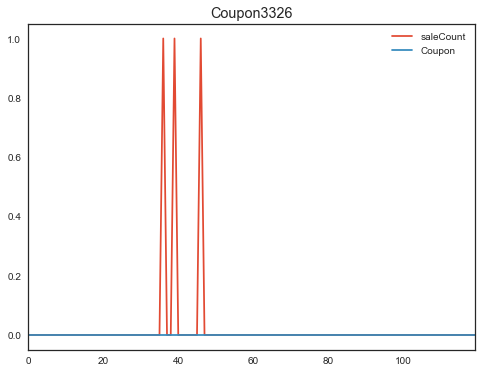

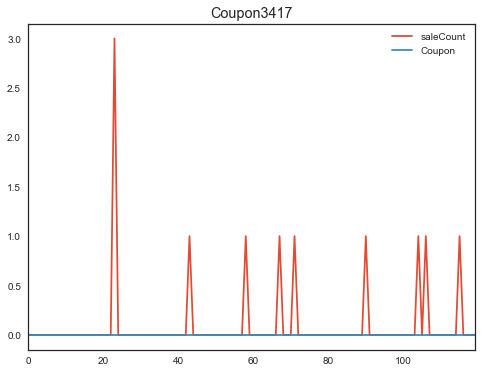

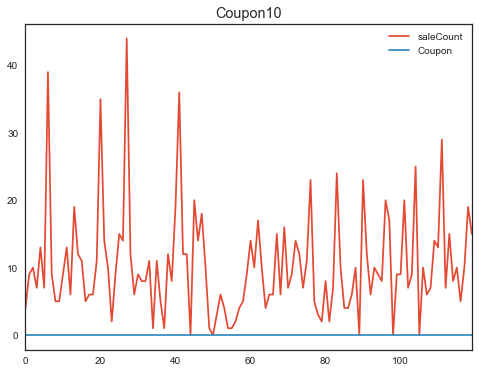

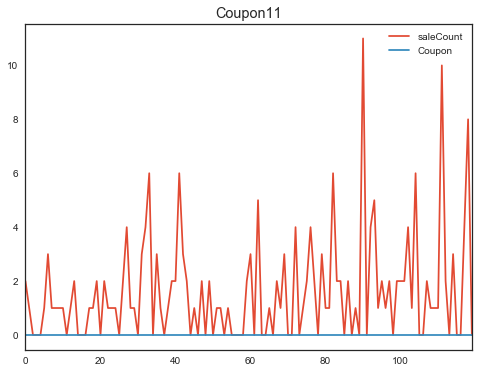

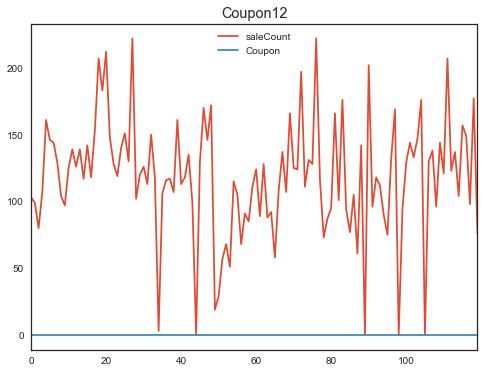

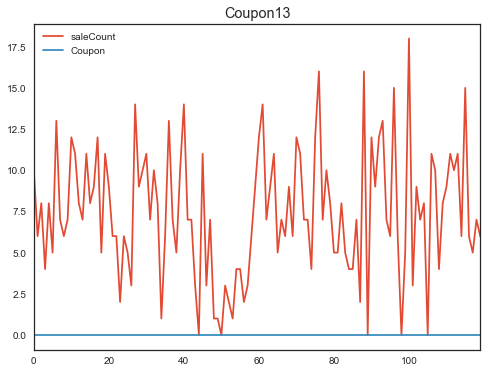

In [152]:
import time
path= 'class_pics/nocoupon/'
for i in nct:  
    className = i
    var_1 = train_new[train_new['Class'] == className].groupby('SaleDate',as_index=False)['saleCount'].mean()
    var_2 = train_new[train_new['Class'] == className].groupby('SaleDate',as_index=False)['Coupon'].mean()
    var = pd.merge(var_1, var_2 , on= 'SaleDate', how='left')
    # var['SaleDate'] = var['SaleDate'].astype('float')
    var.plot(title= 'Coupon' + str(className))
    fileName = path + str(className) + '.jpg'
    plt.savefig(fileName)
#     var.colse(fileName)
#     _.get_figure().clear()
#     pylab.colse()
    time.sleep(1)

count    120.000000
mean       0.108333
std        0.361970
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: saleCount, dtype: float64

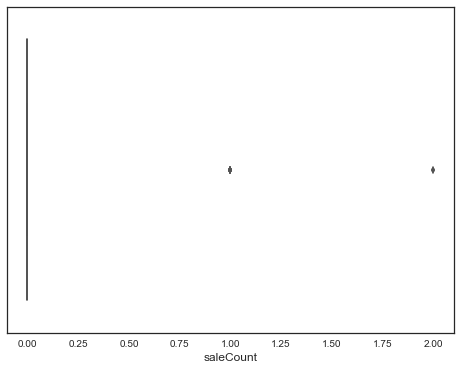

In [10]:
var_1 = train_new[train_new['Class'] == 1502].groupby('SaleDate',as_index=False)['saleCount'].mean()
ax = sns.boxplot(x=var_1["saleCount"])
var_1['saleCount'].describe()

In [26]:
var_1['saleCount'].value_counts()

0    109
1      9
2      2
Name: saleCount, dtype: int64

count    120.000000
mean       0.108333
std        0.361970
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: saleCount, dtype: float64

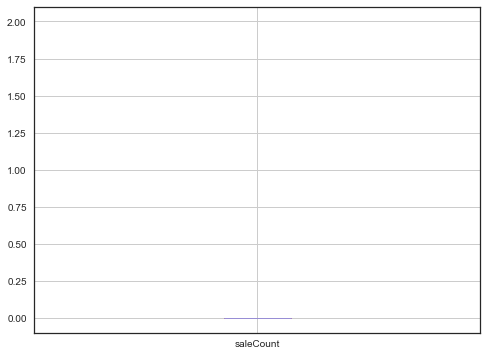

In [24]:
var_1 = train_new[train_new['Class'] == 1502].groupby('SaleDate',as_index=False)['saleCount'].mean()
p = var_1.boxplot()
# x = p['fliers'][0].get_xdata() # 'flies'即为异常值的标签.[0]是用来标注第1位歌手的异常值数值,同理[i]标注第i+1位歌手的异常值.
# y = p['fliers'][0].get_ydata()
var_1['saleCount'].describe()
# p.format_xdata

In [15]:
def plot_ts_day(x,y):
    """绘制每天的时间序列图。
    需要注意的是，序列是不是连续的，也就是说某天的数据是没有的,因此需要采样至每天都有记录，原来数据没有的就填充0
    x:时间轴，string或者time类型,是一个seires
    y:值
    """
    # x转成时间类型Timestamp，y也转成list
    x=[pd.to_datetime(str(i)) for i in x]
    y=[i for i in y]
    s=pd.Series(y,index=x)
    s = s.resample(rule='D',fill_method='ffill') # 生采样没有的会被填充
    # 原来没有的就填充为0
    s[s.index]=0
    s[x]=y
    # 重建索引，画出来的图好看点
    x2 = [i.strftime('%Y-%m-%d') for i in s.index]
    s.index = x2
    # 画图，这里使用series的plot函数，而不是seaborn.tsplot函数
    s.plot()

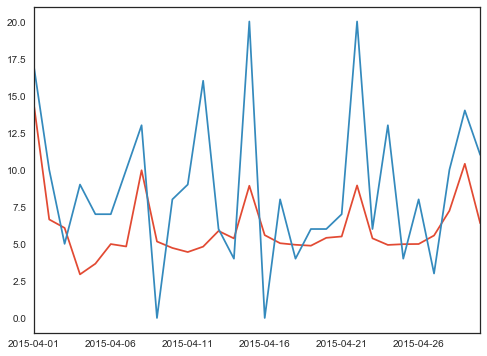

In [16]:
result = pd.read_csv('result.csv')
test_valid = pd.read_csv('test_valid.csv')
# plot_ts_day(result['SaleDate'][result['Class'] == 1001],result['saleCount'][result['Class'] == 1001])
# plot_ts_day(result['SaleDate'][result['Class'] == 1001],result['saleCount.1'][result['Class'] == 1001])

In [19]:
import time
path= 'class_pics'
for i in result.Class.unique():  
    className = i
#     var_1 = train_new[train_new['Class'] == className].groupby('SaleDate',as_index=False)['saleCount'].mean()
#     var_2 = train_new[train_new['Class'] == className].groupby('SaleDate',as_index=False)['Coupon'].mean()
    
#     var = pd.merge(var_1, var_2 , on= 'SaleDate', how='left')
    var = result[['SaleDate','saleCount','saleCount_t']][result['Class'] == i]
    # var['SaleDate'] = var['SaleDate'].astype('float')
    var.plot(title= 'Coupon' + str(className))
    fileName = path + str(className) + '.jpg'
    plt.savefig(fileName)
#     var.colse(fileName)
#     _.get_figure().clear()
#     pylab.colse()
    time.sleep(1)

KeyError: "['saleCount_t'] not in index"

In [ ]:
np.ceil